In [1]:
#Libraries
%matplotlib notebook
import os
import openpyxl
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
from pandas import DataFrame, read_csv
from scipy.special import gamma, factorial
import numpy as np
from PIL import Image
import scipy.misc
import matplotlib.pyplot as plt
import matplotlib.axes
import matplotlib.cm as cmx
import itertools
import scipy.interpolate
import time
import pandas as pd
import math
import matplotlib.animation as animation
from scipy import stats
from bayes_opt import BayesianOptimization
from bayes_opt import UtilityFunction
from bayes_opt import SequentialDomainReductionTransformer

In [2]:
#serial implementation with optimization
#import data containing parameters for the GND functions for set w's. Behavior differs between Fully and Partially embedded Particles.
# Columns of w provide values of,alpha,beta,sigma,x_m,Em in each row for the w
Full = pd.read_excel('GND Full Rad.xlsx',header=None) 
#trim data to get rid of empty excel cells
Full=Full.dropna(axis=0,how='all')
Full=Full.dropna(axis=1,how='all')
GND_Full=Full.values
Part = pd.read_excel('GND Part Rad.xlsx',header=None)
#trim data to get rid of empty excel cells
Part=Part.dropna(axis=0,how='all')
Part=Part.dropna(axis=1,how='all')
GND_Part=Part.values



#function to find height at coordinates x,y
def postoheight(x,y):
    return heightmap[np.array(y/pic_size*(pic_height-1),dtype='int'),np.array(x/pic_size*(pic_width-1),dtype='int')]
#define GND function. Each w is used to select parameters and d is used as in imput to the function
#inputs are alpha, beta,sigma, x_m, Em, and depth
def GNDModel (a,b,s,x_m,Em,dpos):
    
        Eeff = Em-3.2+a*b/(2*s*gamma(1/b))*np.exp(-(np.abs(dpos/x_m/s)**b))
        return Eeff
    

#calulate distance from every location x,y in an array from the particle at x_center,y_center
def radius(x, y, x_center, y_center):
        return np.sqrt((x - x_center) ** 2 + (y - y_center) ** 2)
#interpolate modulus values based on w
#GND is either the fully or partially embeddded GND data
#idx1 and idx2 are index's for the GND function value, w is distance, dpos is depth. 
def lininterp (GND, idx1, idx2, w,dpos):
        Ztemp1=GNDModel(GND[1,idx1],GND[2,idx1],GND[3,idx1],GND[4,idx1],GND[5,idx1],dpos)
        Ztemp2=GNDModel(GND[1,idx2],GND[2,idx2],GND[3,idx2],GND[4,idx2],GND[5,idx2],dpos)
        Z=(Ztemp2-Ztemp1)/(GND[0,idx2]-GND[0,idx1])*(w-GND[0,idx1])+Ztemp1
        return Z
#overall function to simulate a modulus map
#inputs are x and y position of the particle, depth,
#and pic_size is the physical size of the area looked at defiend as a length of a square
def simulated_mod(xpos,ypos,depth, pic_size):

    #create an array with by assigning a coordiate to every potential modulus data point in the importated data
    # pic_width and pic_length  is size of the array
    x = np.linspace(0, pic_size, pic_width)
    y = np.linspace(0, pic_size, pic_height)
    X, Y = np.meshgrid(x, y)
    

    # generating radius based on X and Y coordinates distance to xpos and ypos
    rad = radius(X, Y,  xpos, ypos)
    
    # instead of finding matching rad to the database w values based on each entry in the loop, find all of them before hand
    #and store them in a matrix
    alldiffFull=np.zeros((np.size(GND_Full[0])-1,pic_width,pic_height))
    #for each w value stored in a GND matrix
    for i in range(len(GND_Full[0])-1):
        #calculate w for each datapoint
        alldiffFull[i]=rad-GND_Full[0,i+1]
        #find closest distance ind GND matrix to the actual distance and
        #store the index value
        idxFull=np.nanargmin(np.abs(alldiffFull),0)+1

    alldiffPart=np.zeros((np.size(GND_Part[0])-1,pic_width,pic_height))
    for i in range(len(GND_Part[0])-1):
        alldiffPart[i]=rad-GND_Part[0,i+1]
        idxPart=np.nanargmin(np.abs(alldiffPart),0)+1
    #find closest w value in the database
    Full_Close=GND_Full[0,idxFull]
    Part_Close=GND_Part[0,idxPart]
    #find which side of the closest GND database value idx1 is on, then find the index value on the other side of w to
    #later allow for interpolation
    idx_Full_Above=rad>Full_Close
    idx_Full_Below=rad<Full_Close
    idxFull2=idxFull+idx_Full_Above-idx_Full_Below
    idx_Part_Above=rad>Part_Close
    idx_Part_Below=rad<Part_Close
    idxPart2=idxPart+idx_Part_Above-idx_Part_Below
    Z = np.ones(rad.shape)

    #Find Z coordiante based on particle dapth and location
    #for positions within the are of interest
    if ypos>=0 and ypos<=pic_size and xpos>=0 and xpos<=pic_size:
        if depth<0:
            depth=0
        absdepth=int(heightmap[int(ypos/pic_size*(pic_height-1)),int(xpos/pic_size*(pic_width-1))])-depth
    else:
        absdepth=-depth

#entering d,x,y to find modulus values
    for i in range(len(x)):
            for j in range(len(y)):
                dpos=heightmap[i,j]-absdepth
                #fully embedded
                if (dpos>0):
                    #indexes indicate which w values to interpolate between
                    idx=idxFull[i,j]
                    idx2=idxFull2[i,j]
                    if idx2!=len(GND_Full[0]) and idx!=idx2:
                        Z[i,j]=lininterp(GND_Full,idx,idx2,rad[i,j],dpos)
                    else:
                        Z[i, j] = GNDModel(GND_Full[1,idx],GND_Full[2,idx],GND_Full[3,idx],GND_Full[4,idx],GND_Full[5,idx],dpos)   
                #partially embedded
                elif (-71<=dpos<=0):
                    #if to close to center of particle, =8.55
                    if rad[i, j]<GND_Part[0,1]:
                        Z[i,j]=8.55
                    else:    
                        idx=idxPart[i,j]
                        idx2=idxPart2[i,j]
                        if idx2!=len(GND_Part[0]) and idx!=idx2:
                            Z[i,j]=lininterp(GND_Part,idx,idx2,rad[i,j],dpos+71)
                        else:
                            Z[i, j] = GNDModel(GND_Part[1,idx],GND_Part[2,idx],GND_Part[3,idx],GND_Part[4,idx],GND_Part[5,idx],dpos+71)   
                 #if way below particle, dont add anything
                else:
                    Z[i,j]=0
                
                        
    return Z

## Wrappig the function just to take (d, x, y) as input

### Here we are writing a function which take real image and ranges of our parameters to explore.

#### Current bayesian optimization hyperparameters works for default ranges of positional parameters, but if we change those ranges drastically then we have to iterate again for finding optimal hyperparameters.

#### We have to fix these ranges based on real images we cut from our big raw image

In [3]:

#use simulated mod at set cooridatesbased on x and y position and particle depth
def generate_image(xpos,ypos,depth):
        return simulated_mod(xpos,ypos,depth, pic_size)
#find weight for each datapoint
def findweight(xpos,ypos):
       #create an array with by assigning a coordiate to every potential modulus data point in the importated data
        # pic_width and pic_length  is size of the array
        # if the image is not flat
        if flat==0:
            #weights based on zscores
            zheight=stats.zscore(heightmap,axis=None)
            #only apply weight if particle is in bounds/area of interst
            if ypos>=0 and ypos<=pic_size and xpos>=0 and xpos<=pic_size:
                #apply weights
                zheight=zheight-zheight[int(round((ypos)/pic_size*(pic_width-1))),int(round((xpos)/pic_size*(pic_height-1)))]
                prob=1-(abs(stats.norm.cdf(zheight/4)-stats.norm.cdf(-zheight/4)))
                #make average of the weight 1
                scale=((zheight).size/sum(sum(prob)))
                weight=prob*scale
            else:
                weight=np.zeros([pic_height,pic_width])
        #if the image is flat, no weights/all points have equal weights
        else:
            weight=np.ones((160,160))
        return weight
#create a modulus contour with animation dataframes as an input
def contoursimanimate(frame):
        #predicted contour
        predictguesses=plt.contour(np.linspace(0, pic_size, pic_height), np.linspace(0, pic_size, pic_height), countorsim(**animationdata[frame]), levels=[3.2,4,5,6,7,8,8.55],zorder=2)

        #contour for actual data
        Actual=plt.contour(np.linspace(0, pic_size, pic_height), np.linspace(0, pic_size, pic_height), real_image, levels=[3.2,4,5,6,7,8,8.55],zorder=1)

        #plot centers
        Centerguesses=plt.scatter(centerxguesses, centeryguesses, color = "black",zorder=3)

        plt.title('iteration: '+str (iteration2guesses[i])+' error: '+str (round(errorminguesses[i],3))+' '+str (outputguesses)+' global depth='+str(globaldepthtemp)+'')

        return predictguesses
#Find modulus values with number and partilces, x,y,d of each particle coordinate as inputs 
def contoursim(nactual,**kwargs):
        Et=np.zeros((pic_height, pic_width))
        #base modulus is 3.2
        Et=Et+3.2
        for i in range(nactual):
            #create strings of a position's name
            xntemp='x' + str(i+1) + ''

            yntemp='y' + str(i+1) + ''

            dntemp='d' + str(i+1) + ''


            #create the simulated modulus at set coordinates choosen through baysian
            generated_image= generate_image(kwargs[xntemp], kwargs[yntemp], kwargs[dntemp])
            #add current particle contribution to current contributions
            Et=Et+generated_image
            Et = np.where(Et < 8.55, Et, 8.55)


        #which is the lowest cost
        return Et

#compare simulated and actual contours with  xyd of each particle coordinate as inputs      
def costfun(**kwargs):

        
        #Et contains the total effect of all looked at particles as they are added with entry 0 being the min value
        Et=np.zeros((pic_height, pic_width))
        
        #Base = matrix value
        Et=Et+3.2
        
        #_all contains every name of every position as a string
        xnall=[0]*(int(len(kwargs)/3))
        ynall=[0]*(int(len(kwargs)/3))
        dnall=[0]*(int(len(kwargs)/3))
        absdepthall=[0]*(int(len(kwargs)/3))
        weights=np.zeros((pic_height, pic_width))
        #for every possible position
        for i in range(int(len(kwargs)/3)):
            #create strings of a position's name and the next one. 
            impos=0
            xntemp='x' + str(i+1) + ''
            xntemp2='x' + str(i+2) + ''
    
            yntemp='y' + str(i+1) + ''
            yntemp2='y' + str(i+2) + ''
    
            dntemp='d' + str(i+1) + ''
            dntemp2='d' + str(i+2) + ''
            
            #add the name to the list of names
            xnall[i]=xntemp
            ynall[i]=yntemp
            dnall[i]=dntemp
            #Convert d to z(absdepth) based on x and y
            if kwargs[yntemp]>=0 and kwargs[yntemp]<=pic_size and kwargs[xntemp]>=0 and kwargs[xntemp]<=pic_size:
                if kwargs[dntemp]<0:
                    absdepth=int(heightmap[int(kwargs[yntemp]/pic_size*(pic_width-1)),int(kwargs[xntemp]/pic_size*(pic_height-1))])
                else:
                    absdepth=int(heightmap[int(kwargs[yntemp]/pic_size*(pic_width-1)),int(kwargs[xntemp]/pic_size*(pic_height-1))])-kwargs[dntemp]
                
            else:
                absdepth=-kwargs[dntemp]
            #store z values
            absdepthall[i]=absdepth
            x = np.linspace(0, pic_size, pic_width)
            y = np.linspace(0, pic_size, pic_height)
            X, Y = np.meshgrid(x, y)
            rad = radius(X, Y,  kwargs[xntemp], kwargs[yntemp])

                        
            #Find the Effect of the i+1 particle
            generated_image= generate_image(kwargs[xntemp], kwargs[yntemp], kwargs[dntemp])
            #Find the total effect of all current particles
            Et=Et+generated_image
            #with a max of 8.55
            Et= np.where(Et < 8.55, Et, 8.55)
            #find difference
            difference=Et- real_image
            #apply weight
            weights=weights+findweight(kwargs[xntemp], kwargs[yntemp])
            scale=((real_image).size/sum(sum(weights)))
            weight=weights*scale
            weighteddiff=weight*difference
            #Find the cost of of this current map after normalization
            cost=-1*np.sum(np.sum(abs(weighteddiff)))/costnorm
            
            z= np.where(rad < 71, np.sqrt(71**2-np.square(rad))+absdepth-71,0)
            #make sure the particle doesnt stick out of the surface too far
            apheight=np.where(rad < 71, heightmap,0)
            heightdiff=apheight-z
            if np.any(heightdiff <-30):
                #otherwise output an error
                cost=(-failerror)
                impos=1
                break
                
            #if this is not the last particle
            #for every current particle
            for j in range(i):
                #calculate the distance to the next particle
                distance=math.sqrt((kwargs[xnall[j]]-kwargs[xntemp])**2+(kwargs[ynall[j]]-kwargs[yntemp])**2+(absdepthall[j]-absdepth)**2)
                #If any distance is to small/impossible
                if distance<142:
                    #Output a an impossible error
                    cost=(-failerror)
                    impos=1
                    break
            if impos==1:
                break


        return cost 

    

#Baysian optization function to find partilce within a modulus data input
def find_position_single_ball(real_image):  
        #defien global variables
        global xbounds
        global ybounds
        global dbounds
        global xprobes
        global yprobes
        global dprobes
        #defien storage variables
        costs=np.ones((nguessmax))*-failerror
        output=[0]*nguessmax
        eachmax=[0]*nguessmax
        allguesses=[]
        probe=[]
        probe1=[]
        xnall=[0]*(nguessmax)
        ynall=[0]*(nguessmax)
        dnall=[0]*(nguessmax)
        results=[]
        probenumber=[0]*(nguessmax)
        #create coordinates to probe in a 3d grid size chosen by probedef for 1 particle
        for x in range (int(round(probedef))):
            for y in range (int(round(probedef))):
                for z in range (int(round(probedef))):
                    if real_image[int(y*(pic_width-1)/(probedef-1)),int(x*(pic_height-1)/(probedef-1))] > np.max(real_image)*.9:
                        probe1.append({'x1':(pic_size/(probedef-1)*x),'y1':(pic_size/(probedef-1)*y),'d1':(-20+(np.max(heightmap)-np.min(heightmap))/(probedef-1)*z)})

        probe.append(probe1)
        #Keep increasing the number of particles gussed starting at 1, up to nguessmax
        for i in range(nguessmax):
            #Create strings to call for positions in a dict
            xntemp='x' + str(i+2) + ''
            yntemp='y' + str(i+2) + ''
            dntemp='d' + str(i+2) + ''
            xntemp1='x' + str(i+1) + ''
            yntemp1='y' + str(i+1) + ''
            dntemp1='d' + str(i+1) + ''
            xnall[i]=xntemp1
            ynall[i]=yntemp1
            dnall[i]=dntemp1
            #Define Baysian function 
            bo = BayesianOptimization(costfun, {**xbounds,**ybounds,**dbounds})
            proben=[]
            #create coordinates to probe at the intersections of a 3d grid which size chosen by probedef for the ith particle
            if i != nguessmax-1:
                for x in range (int(round(probedef))):
                    for y in range (int(round(probedef))):
                        for z in range (int(round(probedef))):
                            xval=-20+(pic_size+20)/(probedef-1)*x
                            yval=-20+(pic_size+20)/(probedef-1)*y
                            if xval <=pic_size and xval >=0 and yval <=pic_size and yval >=0:
                                if real_image[int(y*(pic_width-1)/(probedef-1)),int(x*(pic_height-1)/(probedef-1))] > np.max(real_image)*.9:
                                    proben.append({xntemp:(xval),yntemp:(yval),dntemp:(-71+142/(probedef-1)*z)})
                            else:
                                proben.append({xntemp:(xval),yntemp:(yval),dntemp:(multipartrangehigh+multipartrangelow/(probedef-1)*z)})

            probetemp=[]      
            #Find all possible combos of intersections of 3d grids to form intersections of 3*i dimensional grids to probe at 
            #i=number of particles already looked, j =position number or simply an index in the currently observed 3d grid 
            for j in range(len(probe[i])):
                #k is the current particle number
                if i != nguessmax-1:
                    for k in range(len(proben)):
                        imposs=0
                        #find z coordiante
                        if proben[k][yntemp]>=0 and proben[k][yntemp]<=pic_size and proben[k][xntemp]>=0 and proben[k][xntemp]<=pic_size:
                            if proben[k][dntemp]<0:
                                absdepth=int(heightmap[int(proben[k][yntemp]/pic_size*(pic_width-1)),int(proben[k][xntemp]/pic_size*(pic_height-1))])
                            else:
                                absdepth=int(heightmap[int(proben[k][yntemp]/pic_size*(pic_width-1)),int(proben[k][xntemp]/pic_size*(pic_height-1))])-proben[k][dntemp]

                        else:
                            absdepth=-proben[k][dntemp]

                        x = np.linspace(0, pic_size, pic_width)
                        y = np.linspace(0, pic_size, pic_height)
                        X, Y = np.meshgrid(x, y)
                        rad = radius(X, Y,  proben[k][xntemp],proben[k][yntemp])
                        #Make sure the particle isn't too impossible ie to far above the surface
                        z= np.where(rad < 71, np.sqrt(71**2-np.square(rad))+absdepth-71,0)
                        apheight=np.where(rad < 71, heightmap,0)
                        heightdiff=apheight-z
                        if np.any(heightdiff <-30):
                            imposs=1
                        #Make sure grid combination doesn't place particle impossibly close to each other 
                        if imposs==0:
                            for l in range(i+1):
                                if math.sqrt((probe[i][j][xnall[l]]-proben[k][xntemp])**2+(probe[i][j][ynall[l]] - proben[k][yntemp])**2+ (probe[i][j][dnall[l]] - proben[k][dntemp])**2)<142:# probe[i] is all position of all past partilces [i][j], current pos of ''proben=all possible position of current particle
                                    imposs=1
                                    break

                        if imposs==0:
                        #if the grid combonation is possible, save it
                            probetemp.append({**(probe[i][j]),**(proben[k])})
                #i=number of particles, j =position number
                #conduct a probe
                bo.probe(probe[i][j])
            probenumber[i]=len(probe[i])
            #save the grid combonations in perminate storage
            probe.append(probetemp)
            
            #I found below hyperparameters of the function by iterating smartly
            bo.maximize(init_points=initial, n_iter=iteration*(i+1), acq=acqfun, xi=acqvalue)
            #save results for each number of guessed particles
            results.append(bo)
            costs[i]=bo.max['target']
            allguesses=np.concatenate((allguesses,bo.res))
            #make sure cost is decreasing as particles are added, otherwise stop optimizing
            if costs[i]<costs[i-1]:
                finalcost=costs[i-1]
                nactual=i
                break
            finalcost=costs[i]
            nactual=i+1

            #create bounds for the particle to be added next
            xboundstemp={xntemp:(-40,pic_size+40)}
            xbounds={**xbounds,**xboundstemp}
            

            yboundstemp={yntemp:(-40,pic_size+40)}
            ybounds={**ybounds,**yboundstemp}


            dboundstemp={dntemp:(multipartrangehigh,multipartrangelow)}
            dbounds={**dbounds,**dboundstemp}
             
            #store center location  output for 1st particle
            outputall={"x1": int(round(bo.max['params']['x1'])),
                "y1": int(round(bo.max['params']['y1'])),
                "d1": int(round(bo.max['params']['d1']))}

            output={"x1": int(round(bo.max['params']['x1'])),
                "y1": int(round(bo.max['params']['y1'])),
                "d1": int(round(bo.max['params']['d1']))}

            centerx=[output['x1']]
            centery=[output['y1']]
            #store errors
            eachmax[i]=bo.max
        #locate all centers for particles to graph
        for i in range(nactual-1):
            xntemp='x' + str(i+2) + ''

            yntemp='y' + str(i+2) + ''


            dntemp='d' + str(i+2) + ''

            outputtemp={xntemp: int(round(eachmax[nactual-1]['params'][xntemp])),
                yntemp: int(round(eachmax[nactual-1]['params'][yntemp])),
                dntemp: int(round(eachmax[nactual-1]['params'][dntemp]))}
            output={**output,**outputtemp}
            centerx=np.concatenate((centerx, [output[xntemp]]))
            centery=np.concatenate((centery, [output[yntemp]]))

        #create a map for the predicted particle

        #save simulated modulus contour
        position=contoursim(nactual,**output)


    # returning cost because we will use it to compare the costs from multiple ball simulation and choose the best
        return [output,nactual,finalcost,position,centerx,centery,allguesses,probenumber,results]

<IPython.core.display.Javascript object>


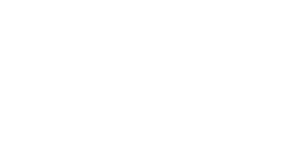

<IPython.core.display.Javascript object>


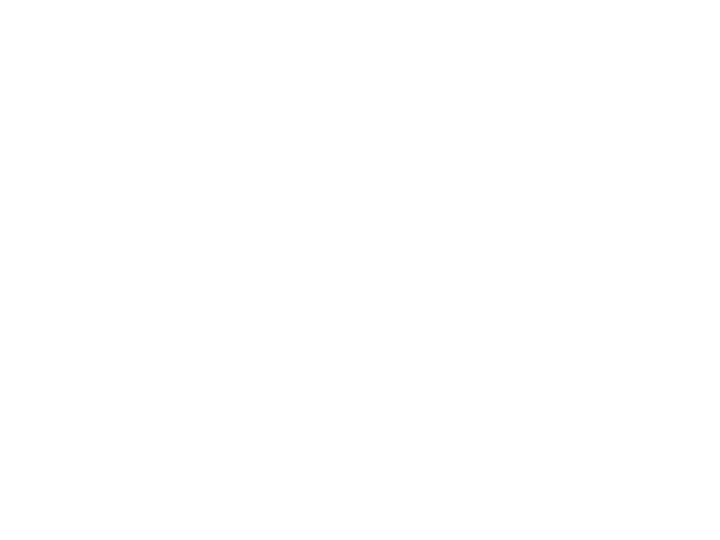

<IPython.core.display.Javascript object>


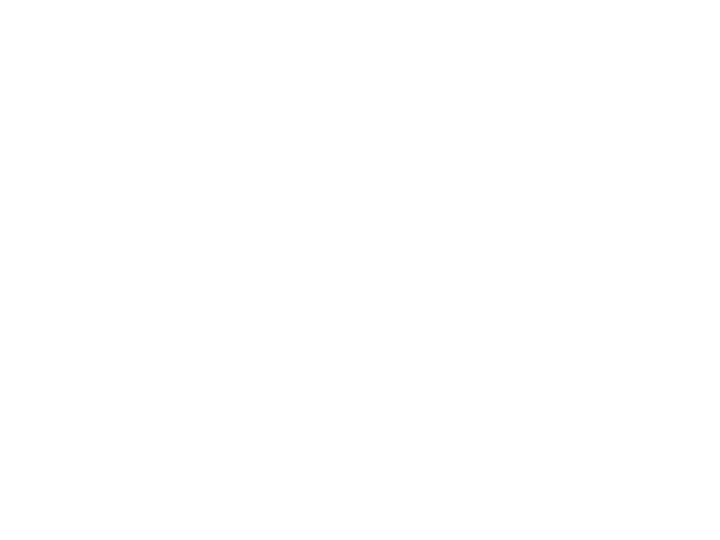

<IPython.core.display.Javascript object>


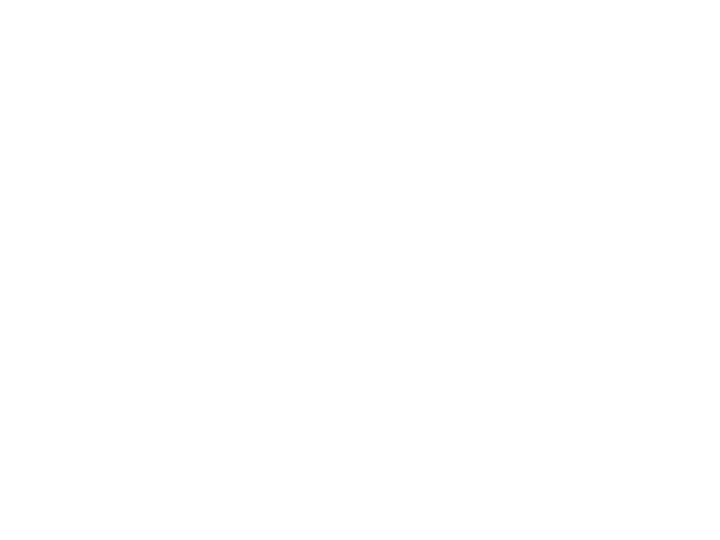

<IPython.core.display.Javascript object>


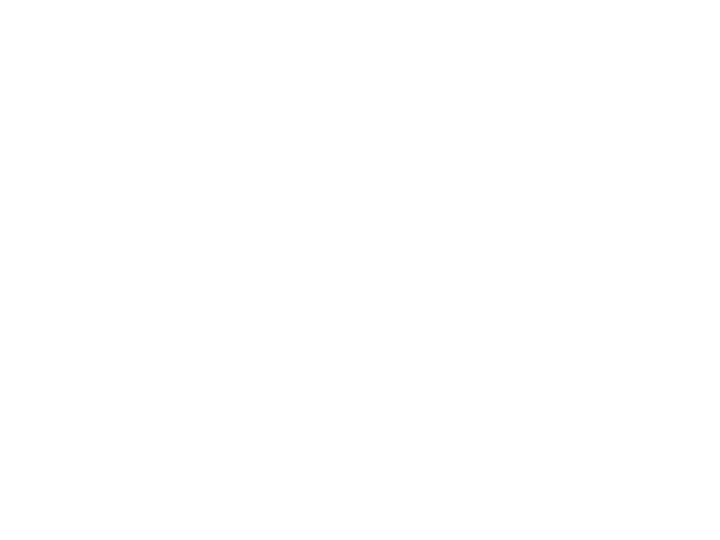

In [36]:
fig = plt.figure()
ax = plt.axes(xlim=(0, pic_size), ylim=(0, pic_size),aspect=1)  
plt.xlabel('nm',fontsize=12)
plt.ylabel('nm',fontsize=12)
plt.xticks(fontsize= 12)
plt.yticks(fontsize= 12)
predict=plt.contour(np.linspace(0, pic_size, pic_height), np.linspace(0, pic_size, pic_height), position, levels=[3.2,4,5,6,7,8,8.55],zorder=2)

#contour for actual data
Actual=plt.contour(np.linspace(0, pic_size, pic_height), np.linspace(0, pic_size, pic_height), real_image, levels=[3.2,4,5,6,7,8,8.55],zorder=1)

#plot centers
Center=plt.scatter(centerx, centery, color = "black",zorder=3)
plt.title(r'Error='+str(round(-finalcost,3))+'\n'+str (positionguess)+' nm\nGlobal Depth= '+str(globaldepth)+' nm')
plt.savefig(''+prefix+' contour, acqfun=' + str(acqfun) + ', acqvalue= ' + str(acqvalue) + ', probe v3= ' + str(probedef) + ', initial=' + str(initial) + ', iteration=' + str(iteration) + ', total steps=' + str(len(allguesses)) + ', data='+Data+',varaible n v4 with height v3.5, weight v3, outside, cost=' + str(round(-finalcost,3)) + ', t=' + str(int(round(runtime))) +'.png',bbox_inches="tight")
plt.close()

fig = plt.figure()
ax = plt.axes(xlim=(0, pic_size), ylim=(0, pic_size),aspect=1)  
plt.xlabel('nm',fontsize=12)
plt.ylabel('nm',fontsize=12)
plt.xticks(fontsize= 12)
plt.yticks(fontsize= 12)

#contour for actual data
Actual=plt.contour(np.linspace(0, pic_size, pic_height), np.linspace(0, pic_size, pic_height), real_image, levels=[3.2,4,5,6,7,8,8.55],zorder=1)

plt.title(r'Error='+str(round(-finalcost,3))+'\n'+str (positionguess)+' nm\nGlobal Depth= '+str(globaldepth)+' nm')
plt.savefig(''+prefix+' Acontour, acqfun=' + str(acqfun) + ', acqvalue= ' + str(acqvalue) + ', probe v3= ' + str(probedef) + ', initial=' + str(initial) + ', iteration=' + str(iteration) + ', total steps=' + str(len(allguesses)) + ', data='+Data+',varaible n v4 with height v3.5, weight v3, outside, cost=' + str(round(-finalcost,3)) + ', t=' + str(int(round(runtime))) +'.png',bbox_inches="tight")
plt.close()

fig = plt.figure()
ax = plt.axes(xlim=(0, pic_size), ylim=(0, pic_size),aspect=1)  
plt.xlabel('nm',fontsize=12)
plt.ylabel('nm',fontsize=12)
plt.xticks(fontsize= 12)
plt.yticks(fontsize= 12)
predict=plt.contour(np.linspace(0, pic_size, pic_height), np.linspace(0, pic_size, pic_height), position, levels=[3.2,4,5,6,7,8,8.55],zorder=2)

#plot centers
Center=plt.scatter(centerx, centery, color = "black",zorder=3)
plt.title(r'Error='+str(round(-finalcost,3))+'\n'+str (positionguess)+' nm\nGlobal Depth= '+str(globaldepth)+' nm')
plt.savefig(''+prefix+' Scontour, acqfun=' + str(acqfun) + ', acqvalue= ' + str(acqvalue) + ', probe v3= ' + str(probedef) + ', initial=' + str(initial) + ', iteration=' + str(iteration) + ', total steps=' + str(len(allguesses)) + ', data='+Data+',varaible n v4 with height v3.5, weight v3, outside, cost=' + str(round(-finalcost,3)) + ', t=' + str(int(round(runtime))) +'.png',bbox_inches="tight")
plt.close()
#plot cost for each iteration

allerror=np.zeros(len(allguesses))

#x=number of iterations
alliteration2=np.linspace(1, len(allguesses),len(allguesses))

#y=cost
for i in range(len(allguesses)):
    allerror[i]=-allguesses[i]['target']
allerror = np.where(allerror <failerror, allerror, float('NaN'))
plotit=0
for i in range(nguessmax):
    plt.scatter(alliteration2[plotit:probenumber[i]],allerror[plotit:probenumber[i]],s=1,color='red',zorder=1)
    plotit+=probenumber[i]
    plt.scatter(alliteration2[plotit:plotit+initial],allerror[plotit:plotit+initial],s=1,color='blue',zorder=1)
    plotit+=initial
    plt.scatter(alliteration2[plotit:plotit+iteration*(i+1)],allerror[plotit:plotit+iteration*(i+1)],s=1,color='green',zorder=1)
    plotit+=iteration*(i+1)
#current min cost graph +9999999 to ensure it starts high
allerrormin=np.ones(len(allguesses))*failerror

#x=number of iterations
alliteration2=np.linspace(1, len(allguesses),len(allguesses))

for i in range(len(allguesses)):
    #y=cost
    allerrormin[i]=-allguesses[i]['target']

    #only if its less than before
    if allerrormin[i]>allerrormin[i-1]:
        allerrormin[i]=allerrormin[i-1]
    else:
        plt.scatter(alliteration2[i],allerrormin[i],color='black',s=5,zorder=3)
plt.plot(alliteration2,allerrormin,linewidth=1,color='orange',zorder=2)

plt.legend(['Minimum Error','Probes','Random Sampling','Optimization',],bbox_to_anchor=(.5, 1.1), loc='upper center', ncol=4)
plt.xlabel('Iteration',fontsize=12)
plt.ylabel('Error',fontsize=12)
plt.xticks(fontsize= 12)
plt.yticks(fontsize= 12)
plt.savefig(''+prefix+' All error, acqfun=' + str(acqfun) + ', acqvalue= ' + str(acqvalue) + ', probe v3= ' + str(probedef) + ', initial=' + str(initial) + ', iteration=' + str(iteration) + ', total steps=' + str(len(allguesses)) + ', data='+Data+',varaible n v4 with height v3.5, weight v3, outside, cost=' + str(round(-finalcost,3)) + ', t=' + str(int(round(runtime))) +'.png',bbox_inches="tight")
plt.close()

#plot cost for each iteration
besterror=np.zeros(iteration*nactual)

#x=number of iterations
bestiteration2=np.linspace(1, iteration*nactual,iteration*nactual)
#startiteration is all iterations of nactaul-optimization iterations
startiteration=len(results[nactual-1].space)-iteration*nactual
#y=cost
for i in np.linspace(startiteration,len(results[nactual-1].space.target)-1,iteration*nactual):
    i=int(i)
    besterror[i-startiteration]=-results[nactual-1].space.target[i]
besterror = np.where(besterror <failerror, besterror, float('NaN'))
plt.scatter(bestiteration2,besterror,color='green',s=1,zorder=1)

#current min cost graph +9999999 to ensure it starts high
besterrormin=np.ones(iteration*nactual)*failerror

#x=number of iterations
bestiteration2=np.linspace(1, iteration*nactual,iteration*nactual)

for i in range(len(results[nactual-1].space.target)):
    if i <startiteration:
        besterrormin[0]=-results[nactual-1].space.target[i]
        if besterrormin[-1]>besterrormin[0]:
            besterrormin[-1]=besterrormin[0]
    if i >=startiteration:
        #y=cost
        besterrormin[i-startiteration]=-results[nactual-1].space.target[i]

        #only if its less than before
        if besterrormin[i-startiteration]>besterrormin[i-1-startiteration]:
            besterrormin[i-startiteration]=besterrormin[i-1-startiteration]
        else:                   
            plt.scatter(bestiteration2[i-startiteration],besterrormin[i-startiteration],color='black',s=5,zorder=3)

plt.plot(bestiteration2,besterrormin,color='orange',linewidth=.5,zorder=2)
bestguessestemp=[]
averagebesterror=np.zeros(iteration*nactual)
rollingaveragebesterror=np.zeros(iteration*nactual)
rollingaveragetemp=np.zeros(50)
for i in np.linspace(startiteration,len(results[nactual-1].space.target)-1,iteration*nactual):
    i=int(i)
    bestguessestemp.append(-results[nactual-1].space.target[i])
    averagebesterror[i-startiteration]=np.mean(bestguessestemp)
    rollingaveragebesterror[i-startiteration]=np.mean(bestguessestemp)
    if i <startiteration+50:
        rollingaveragetemp[i-startiteration]=(-results[nactual-1].space.target[i])
        rollingaveragebesterror[i-startiteration]=np.mean(bestguessestemp)
    else:
        rollingaveragetemp=np.delete(rollingaveragetemp,0)
        rollingaveragetemp=np.append(rollingaveragetemp,(-results[nactual-1].space.target[i]))
        rollingaveragebesterror[i-startiteration]=np.mean(rollingaveragetemp)
plt.plot(bestiteration2,rollingaveragebesterror,color='black',linewidth=.5,zorder=2)
#plt.plot(bestiteration2,averagebesterror)
plt.legend(['Minimum Error','Rolling Average','Error'], bbox_to_anchor=(.5, 1.1), loc='upper center', ncol=3)
plt.xlabel('Iteration',fontsize=12)
plt.ylabel('Error',fontsize=12)
plt.xticks(fontsize= 12)
plt.yticks(fontsize= 12)
plt.savefig(''+prefix+' Best error, acqfun=' + str(acqfun) + ', acqvalue= ' + str(acqvalue) + ', probe v3= ' + str(probedef) + ', initial=' + str(initial) + ', iteration=' + str(iteration) + ', total steps=' + str(len(allguesses)) + ', data='+Data+',varaible n v4 with height v3.5, weight v3, outside, cost=' + str(round(-finalcost,3)) + ', t=' + str(int(round(runtime))) +' .png',bbox_inches="tight")
plt.close()

<ipython-input-3-5fabdf3f6c32>:223: RuntimeWarning: invalid value encountered in sqrt
  z= np.where(rad < 71, np.sqrt(71**2-np.square(rad))+absdepth-71,0)


|   iter    |  target   |    d1     |    x1     |    y1     |
-------------------------------------------------------------


<ipython-input-3-5fabdf3f6c32>:126: RuntimeWarning: invalid value encountered in sqrt
  z= np.where(rad < 71, np.sqrt(71**2-np.square(rad))+absdepth-71,0)


|  1        | -0.3607   | -20.0     |  26.5     |  53.0     |
|  2        | -0.3607   | -11.57    |  26.5     |  53.0     |
|  3        | -0.3607   | -3.137    |  26.5     |  53.0     |
|  4        | -0.4169   |  5.294    |  26.5     |  53.0     |
|  5        | -0.4489   |  13.73    |  26.5     |  53.0     |
|  6        | -0.2929   | -20.0     |  53.0     |  53.0     |
|  7        | -0.2929   | -11.57    |  53.0     |  53.0     |
|  8        | -0.2929   | -3.137    |  53.0     |  53.0     |
|  9        | -0.3653   |  5.294    |  53.0     |  53.0     |
|  10       | -0.4329   |  13.73    |  53.0     |  53.0     |
|  11       | -0.4203   | -20.0     |  79.5     |  79.5     |
|  12       | -0.4203   | -11.57    |  79.5     |  79.5     |
|  13       | -0.4203   | -3.137    |  79.5     |  79.5     |
|  14       | -0.4357   |  5.294    |  79.5     |  79.5     |
|  15       | -0.4681   |  13.73    |  79.5     |  79.5     |
|  16       | -0.3563   | -12.23    |  85.15    |  63.68    |
|  17   

<ipython-input-3-5fabdf3f6c32>:126: RuntimeWarning: invalid value encountered in sqrt
  z= np.where(rad < 71, np.sqrt(71**2-np.square(rad))+absdepth-71,0)


|  21       | -0.2761   | -15.28    |  50.54    |  43.26    |


<ipython-input-3-5fabdf3f6c32>:126: RuntimeWarning: invalid value encountered in sqrt
  z= np.where(rad < 71, np.sqrt(71**2-np.square(rad))+absdepth-71,0)


|  22       | -0.2968   | -20.0     |  60.86    |  41.46    |


<ipython-input-3-5fabdf3f6c32>:126: RuntimeWarning: invalid value encountered in sqrt
  z= np.where(rad < 71, np.sqrt(71**2-np.square(rad))+absdepth-71,0)


|  23       | -0.2801   | -7.944    |  53.97    |  43.12    |


<ipython-input-3-5fabdf3f6c32>:126: RuntimeWarning: invalid value encountered in sqrt
  z= np.where(rad < 71, np.sqrt(71**2-np.square(rad))+absdepth-71,0)


|  24       | -0.3077   | -10.13    |  51.28    |  53.81    |


<ipython-input-3-5fabdf3f6c32>:126: RuntimeWarning: invalid value encountered in sqrt
  z= np.where(rad < 71, np.sqrt(71**2-np.square(rad))+absdepth-71,0)


|  25       | -0.284    | -9.606    |  60.81    |  49.93    |


<ipython-input-3-5fabdf3f6c32>:126: RuntimeWarning: invalid value encountered in sqrt
  z= np.where(rad < 71, np.sqrt(71**2-np.square(rad))+absdepth-71,0)


|  26       | -0.3224   | -18.16    |  47.73    |  27.91    |


<ipython-input-3-5fabdf3f6c32>:126: RuntimeWarning: invalid value encountered in sqrt
  z= np.where(rad < 71, np.sqrt(71**2-np.square(rad))+absdepth-71,0)


|  27       | -0.2795   | -12.0     |  55.28    |  47.2     |


<ipython-input-3-5fabdf3f6c32>:126: RuntimeWarning: invalid value encountered in sqrt
  z= np.where(rad < 71, np.sqrt(71**2-np.square(rad))+absdepth-71,0)


|  28       | -0.4466   | -19.63    |  105.3    |  28.78    |


<ipython-input-3-5fabdf3f6c32>:126: RuntimeWarning: invalid value encountered in sqrt
  z= np.where(rad < 71, np.sqrt(71**2-np.square(rad))+absdepth-71,0)


|  29       | -0.3079   | -17.78    |  62.09    |  55.97    |


<ipython-input-3-5fabdf3f6c32>:126: RuntimeWarning: invalid value encountered in sqrt
  z= np.where(rad < 71, np.sqrt(71**2-np.square(rad))+absdepth-71,0)


|  30       | -0.4874   |  31.17    |  104.1    |  0.09725  |
|   iter    |  target   |    d1     |    d2     |    x1     |    x2     |    y1     |    y2     |
-------------------------------------------------------------------------------------------------
|  1        | -0.3923   | -11.57    | -31.96    |  79.5     | -20.0     |  79.5     | -20.0     |
|  2        | -0.3923   | -3.137    | -31.96    |  79.5     | -20.0     |  79.5     | -20.0     |
|  3        | -0.3985   | -3.137    | -26.67    |  79.5     | -20.0     |  79.5     | -20.0     |
|  4        | -0.4078   |  5.294    | -31.96    |  79.5     | -20.0     |  79.5     | -20.0     |
|  5        | -0.4139   |  5.294    | -26.67    |  79.5     | -20.0     |  79.5     | -20.0     |
|  6        | -0.4196   |  5.294    | -21.37    |  79.5     | -20.0     |  79.5     | -20.0     |
|  7        | -0.4401   |  13.73    | -31.96    |  79.5     | -20.0     |  79.5     | -20.0     |
|  8        | -0.4462   |  13.73    | -26.67    |  79.5 

<ipython-input-3-5fabdf3f6c32>:126: RuntimeWarning: invalid value encountered in sqrt
  z= np.where(rad < 71, np.sqrt(71**2-np.square(rad))+absdepth-71,0)


|  15       | -0.4582   | -5.702    | -23.69    |  69.88    | -36.67    |  106.0    | -39.95    |


<ipython-input-3-5fabdf3f6c32>:126: RuntimeWarning: invalid value encountered in sqrt
  z= np.where(rad < 71, np.sqrt(71**2-np.square(rad))+absdepth-71,0)


|  16       | -0.8608   | -9.54     | -42.55    |  96.49    | -40.0     |  101.5    |  4.95     |


<ipython-input-3-5fabdf3f6c32>:126: RuntimeWarning: invalid value encountered in sqrt
  z= np.where(rad < 71, np.sqrt(71**2-np.square(rad))+absdepth-71,0)


|  17       | -0.37     | -7.721    | -38.72    |  66.08    | -11.39    |  74.34    | -40.0     |


<ipython-input-3-5fabdf3f6c32>:126: RuntimeWarning: invalid value encountered in sqrt
  z= np.where(rad < 71, np.sqrt(71**2-np.square(rad))+absdepth-71,0)


|  18       | -0.4826   |  33.73    | -42.55    |  106.0    | -40.0     |  0.6777   |  114.8    |


<ipython-input-3-5fabdf3f6c32>:126: RuntimeWarning: invalid value encountered in sqrt
  z= np.where(rad < 71, np.sqrt(71**2-np.square(rad))+absdepth-71,0)


|  19       | -0.3408   | -7.907    | -41.7     |  80.38    | -31.05    |  62.33    | -40.0     |


<ipython-input-3-5fabdf3f6c32>:126: RuntimeWarning: invalid value encountered in sqrt
  z= np.where(rad < 71, np.sqrt(71**2-np.square(rad))+absdepth-71,0)


|  20       | -0.3941   | -10.21    | -42.55    |  94.91    | -10.65    |  70.36    | -40.0     |


<ipython-input-3-5fabdf3f6c32>:126: RuntimeWarning: invalid value encountered in sqrt
  z= np.where(rad < 71, np.sqrt(71**2-np.square(rad))+absdepth-71,0)


|  21       | -0.4943   |  33.73    | -42.55    |  0.0      |  146.0    |  0.0      |  146.0    |


<ipython-input-3-5fabdf3f6c32>:126: RuntimeWarning: invalid value encountered in sqrt
  z= np.where(rad < 71, np.sqrt(71**2-np.square(rad))+absdepth-71,0)


|  22       | -0.4868   |  33.73    | -42.55    |  102.1    |  146.0    |  0.0      |  146.0    |


<ipython-input-3-5fabdf3f6c32>:126: RuntimeWarning: invalid value encountered in sqrt
  z= np.where(rad < 71, np.sqrt(71**2-np.square(rad))+absdepth-71,0)


|  23       | -0.4369   | -20.0     | -42.55    |  82.81    | -40.0     |  20.47    | -40.0     |


<ipython-input-3-5fabdf3f6c32>:126: RuntimeWarning: invalid value encountered in sqrt
  z= np.where(rad < 71, np.sqrt(71**2-np.square(rad))+absdepth-71,0)


|  24       | -0.4883   |  33.73    | -42.55    |  106.0    | -40.0     |  74.21    |  146.0    |


<ipython-input-3-5fabdf3f6c32>:126: RuntimeWarning: invalid value encountered in sqrt
  z= np.where(rad < 71, np.sqrt(71**2-np.square(rad))+absdepth-71,0)


|  25       | -0.4171   | -20.0     | -42.55    |  0.0      |  146.0    |  79.89    |  146.0    |


<ipython-input-3-5fabdf3f6c32>:126: RuntimeWarning: invalid value encountered in sqrt
  z= np.where(rad < 71, np.sqrt(71**2-np.square(rad))+absdepth-71,0)


|  26       | -0.4581   |  33.73    | -42.55    |  0.0      |  146.0    |  106.0    |  146.0    |


<ipython-input-3-5fabdf3f6c32>:126: RuntimeWarning: invalid value encountered in sqrt
  z= np.where(rad < 71, np.sqrt(71**2-np.square(rad))+absdepth-71,0)


|  27       | -0.422    | -20.0     |  21.18    |  0.0      |  146.0    |  61.87    |  146.0    |


<ipython-input-3-5fabdf3f6c32>:126: RuntimeWarning: invalid value encountered in sqrt
  z= np.where(rad < 71, np.sqrt(71**2-np.square(rad))+absdepth-71,0)


|  28       | -0.8608   | -20.0     | -23.22    |  0.0      |  95.3     |  52.67    |  146.0    |


<ipython-input-3-5fabdf3f6c32>:126: RuntimeWarning: invalid value encountered in sqrt
  z= np.where(rad < 71, np.sqrt(71**2-np.square(rad))+absdepth-71,0)


|  29       | -0.4738   | -20.0     |  8.669    |  0.0      |  146.0    |  106.0    |  146.0    |


<ipython-input-3-5fabdf3f6c32>:126: RuntimeWarning: invalid value encountered in sqrt
  z= np.where(rad < 71, np.sqrt(71**2-np.square(rad))+absdepth-71,0)


|  30       | -0.4672   |  33.73    |  21.18    |  0.0      |  146.0    |  60.19    |  146.0    |


<ipython-input-3-5fabdf3f6c32>:126: RuntimeWarning: invalid value encountered in sqrt
  z= np.where(rad < 71, np.sqrt(71**2-np.square(rad))+absdepth-71,0)


|  31       | -0.3801   |  1.158    | -42.55    |  51.99    | -40.0     |  62.05    | -40.0     |


<ipython-input-3-5fabdf3f6c32>:126: RuntimeWarning: invalid value encountered in sqrt
  z= np.where(rad < 71, np.sqrt(71**2-np.square(rad))+absdepth-71,0)


|  32       | -0.8608   | -20.0     | -42.55    |  0.0      |  146.0    |  106.0    |  93.72    |


<ipython-input-3-5fabdf3f6c32>:126: RuntimeWarning: invalid value encountered in sqrt
  z= np.where(rad < 71, np.sqrt(71**2-np.square(rad))+absdepth-71,0)


|  33       | -0.5129   |  33.73    | -42.55    |  106.0    |  35.1     |  0.0      |  146.0    |


<ipython-input-3-5fabdf3f6c32>:126: RuntimeWarning: invalid value encountered in sqrt
  z= np.where(rad < 71, np.sqrt(71**2-np.square(rad))+absdepth-71,0)


|  34       | -0.4809   |  33.73    |  21.18    |  106.0    | -40.0     |  30.89    |  146.0    |
--- 56.88213753700256 seconds ---


<IPython.core.display.Javascript object>


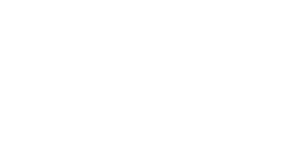

<IPython.core.display.Javascript object>


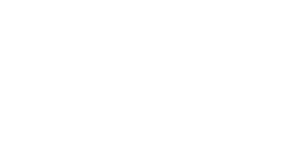

<IPython.core.display.Javascript object>


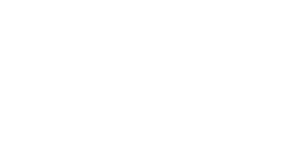

<IPython.core.display.Javascript object>


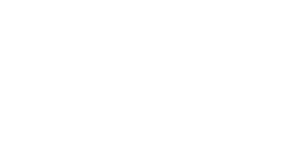

<IPython.core.display.Javascript object>


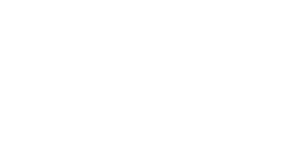

In [5]:
#chooseing graph font
plt.rcParams.update({'font.family':'Arial'})
#select data to read
Data="040"
#Determining if the height data is flat or not, real data should not be flat, so flat=0 for real data
#flat=1 has been used for fully embedded test/synthetic images, but if your test images are more complicated with non-flat heights,use flat=0 
flat=0
#dimension of image in nm
pic_size=106
#import height and modulus data
heightmap = (pd.read_excel(''+Data+'Height32data.xls',header=None, index_col=False)).values
real_image = (pd.read_excel(''+Data+'Modulus32data.xls',header=None, index_col=False)).values
#cost normalization value
costnorm=sum(sum(real_image))
#find lowest impossible error to use if placements are impossible
failerror=5.35*pic_width*pic_height/costnorm
#Prefix to for file names when saving
prefix='Fin'
#random iterations
initial=500
#optimized iterations
iteration=1000
#Maximum number of particels in the immage
nguessmax=2
#number intersections to apply a probe at
probedef=5
#choose acquistion function
acqfun='ei'
#find and save dimensions of data(number of datapoints)
pic_width=real_image.shape[1]
pic_height=real_image.shape[0]

#height bounds for particles after the first particle
multipartrangehigh=-np.max(heightmap)-20
multipartrangelow=-np.min(heightmap)+10
for j in range(1):
    #acquistion function value
    acqvalue=.01
    #coordiante//dimension bounds for x y and depth
    xbounds={'x1': (0,pic_size)}
    ybounds={'y1': (0,pic_size)}
    dbounds={'d1': (-20,np.max(heightmap)-np.min(heightmap))}
    #start a timer to measure exceution length
    start_time = time.time()
    totalsteps=initial+iteration

    #Find position based on moduulus data and output, positions, number of particle, cost(error), modulus data, x coordinate, y coordiante
    #all errors and positions gussed, number of probes used, all errors and positions gussed in another form of data
    (positionguess,nactual,finalcost,position,centerx,centery,allguesses,probenumber,results)=find_position_single_ball(real_image)
    #time to optimize
    print("--- %s seconds ---" % (time.time() - start_time))
    #convert d depths to z coordiantes
    if nactual<=1 and positionguess['y1']>=0 and positionguess['y1']<=pic_size and positionguess['x1']>=0 and positionguess['x1']<=pic_size:
        dguess=positionguess['d1']
        if positionguess['d1']<0:
            dguess=0

        globaldepth=int(heightmap[int(positionguess['y1']/pic_size*(pic_width-1)),int(positionguess['x1']/pic_size*(pic_height-1))])-dguess
    else:
        globaldepth='undefined'
    #save optimization time
    runtime=time.time() - start_time

    #name for sheet in excel file to store final position and cost with all previous runs of same settings
    namestring='' + str(acqfun) + 'v' + str(acqvalue) + 'p3=' + str(probedef) + 'dt'+Data+'n4h3.5w3'
    #open excel file to store gusses and errors for all runs with this data
    book= openpyxl.load_workbook('Error data Hyak040.xlsx')
    #Open sheets
    allsheetnames=book.sheetnames
    if namestring not in allsheetnames: 
        #make a sheet to write in if it doesnt exist
        book.create_sheet(namestring)
    #allow edit of excel file
    writer = pd.ExcelWriter('Error data Hyak040.xlsx', engine='openpyxl')
    #start editing file
    writer.book = book
    #create matri to put into file
    dfin=[round(-finalcost,3),int(round(runtime)),initial,iteration,len(allguesses)]
    #name columns for data
    columntitles=['cost', 'time','initial','iteration','total']
    #repeate last 2 steps for multiple particles
    for i in range (nactual):
        xntemp='x' + str(i+1) + ''


        yntemp='y' + str(i+1) + ''


        dntemp='d' + str(i+1) + ''

        dfin=np.append(dfin,[positionguess[xntemp],positionguess[yntemp],positionguess[dntemp]])
        columntitles=np.append(columntitles,[xntemp,yntemp,dntemp])
    #convert matrix data into dataframe
    df = pd.DataFrame([dfin],columns=columntitles)
    #start editing sheet
    writer.sheets = {ws.title: ws for ws in book.worksheets}
    #write into sheet
    df.to_excel(writer,sheet_name= namestring, startrow=writer.book[namestring].max_row, index = False,header= False)
    #save
    writer.save()
    #create excel file to store all gussed positions and cost for this run
    wb = openpyxl.Workbook()
    #name excel file
    dest_filename ='acqfun=' + str(acqfun) + ', acqvalue= ' + str(acqvalue) + ', probe v3= ' + str(probedef) + ', initial=' + str(initial) + ', iteration=' + str(iteration) + ', total steps=' + str(len(allguesses)) + ', data='+Data+',varaible n v4 with height v3.5, weight v3, outside, cost=' + str(round(-finalcost,3)) + ', t=' + str(int(round(runtime))) +'.xlsx'
    #edit excel file
    ws1 = wb.active
    #name sheet
    ws1.title = "Params"
    # array->list->trunct->cell
    #save gusses
    for i in range (len(results[nguessmax-1].space.params)):
        ws1.append(np.around((results[nguessmax-1].space.params[i]),10).tolist())
    #save errors
    ws2 = wb.create_sheet(title="Error")
    ws2.append(np.around((results[nguessmax-1].space.target),10).tolist())
    #ws3 = wb.create_sheet(title="bounds")
   # boundsv=(np.around(np.vstack(boundsdata),10))
   # boundsv.shape=(int(len(boundsv)/(nactual*3)),nactual*3*2)
   # for i in range(len(boundsv)):
   #     ws3.append((boundsv[i]).tolist()) 
    #save excel file
    wb.save(filename = dest_filename)
    #create figgure for overlapped contours
    fig = plt.figure()
    ax = plt.axes(xlim=(0, pic_size), ylim=(0, pic_size),aspect=1)  
    #figure settigns
    plt.xlabel('nm',fontsize=12)
    plt.ylabel('nm',fontsize=12)
    plt.xticks(fontsize= 12)
    plt.yticks(fontsize= 12)
    #contour for predicted position
    predict=plt.contour(np.linspace(0, pic_size, pic_height), np.linspace(0, pic_size, pic_height), position, levels=[3.2,4,5,6,7,8,8.55],zorder=2)

    #contour for actual data
    Actual=plt.contour(np.linspace(0, pic_size, pic_height), np.linspace(0, pic_size, pic_height), real_image, levels=[3.2,4,5,6,7,8,8.55],zorder=1)

    #plot centers
    Center=plt.scatter(centerx, centery, color = "black",zorder=3)
    plt.title(r'Error='+str(round(-finalcost,3))+'\n'+str (positionguess)+' nm\nGlobal Depth= '+str(globaldepth)+' nm')
    plt.savefig(''+prefix+' contour, acqfun=' + str(acqfun) + ', acqvalue= ' + str(acqvalue) + ', probe v3= ' + str(probedef) + ', initial=' + str(initial) + ', iteration=' + str(iteration) + ', total steps=' + str(len(allguesses)) + ', data='+Data+',varaible n v4 with height v3.5, weight v3, outside, cost=' + str(round(-finalcost,3)) + ', t=' + str(int(round(runtime))) +'.png',bbox_inches="tight")
    plt.close()
    #create figgure for real contour
    fig = plt.figure()
    ax = plt.axes(xlim=(0, pic_size), ylim=(0, pic_size),aspect=1)  
    plt.xlabel('nm',fontsize=12)
    plt.ylabel('nm',fontsize=12)
    plt.xticks(fontsize= 12)
    plt.yticks(fontsize= 12)

    #contour for actual data
    Actual=plt.contour(np.linspace(0, pic_size, pic_height), np.linspace(0, pic_size, pic_height), real_image, levels=[3.2,4,5,6,7,8,8.55],zorder=1)

    plt.title(r'Error='+str(round(-finalcost,3))+'\n'+str (positionguess)+' nm\nGlobal Depth= '+str(globaldepth)+' nm')
    plt.savefig(''+prefix+' Acontour, acqfun=' + str(acqfun) + ', acqvalue= ' + str(acqvalue) + ', probe v3= ' + str(probedef) + ', initial=' + str(initial) + ', iteration=' + str(iteration) + ', total steps=' + str(len(allguesses)) + ', data='+Data+',varaible n v4 with height v3.5, weight v3, outside, cost=' + str(round(-finalcost,3)) + ', t=' + str(int(round(runtime))) +'.png',bbox_inches="tight")
    plt.close()
    #create figgure for predicted contour
    fig = plt.figure()
    ax = plt.axes(xlim=(0, pic_size), ylim=(0, pic_size),aspect=1)  
    plt.xlabel('nm',fontsize=12)
    plt.ylabel('nm',fontsize=12)
    plt.xticks(fontsize= 12)
    plt.yticks(fontsize= 12)
    #contour for predicted position
    predict=plt.contour(np.linspace(0, pic_size, pic_height), np.linspace(0, pic_size, pic_height), position, levels=[3.2,4,5,6,7,8,8.55],zorder=2)

    #plot centers
    Center=plt.scatter(centerx, centery, color = "black",zorder=3)
    plt.title(r'Error='+str(round(-finalcost,3))+'\n'+str (positionguess)+' nm\nGlobal Depth= '+str(globaldepth)+' nm')
    plt.savefig(''+prefix+' Scontour, acqfun=' + str(acqfun) + ', acqvalue= ' + str(acqvalue) + ', probe v3= ' + str(probedef) + ', initial=' + str(initial) + ', iteration=' + str(iteration) + ', total steps=' + str(len(allguesses)) + ', data='+Data+',varaible n v4 with height v3.5, weight v3, outside, cost=' + str(round(-finalcost,3)) + ', t=' + str(int(round(runtime))) +'.png',bbox_inches="tight")
    plt.close()
    
#plot cost for each iteration

    allerror=np.zeros(len(allguesses))

    #x=number of iterations
    alliteration2=np.linspace(1, len(allguesses),len(allguesses))

    #y=cost
    for i in range(len(allguesses)):
        allerror[i]=-allguesses[i]['target']
    #dont plot impossible errors
    allerror = np.where(allerror <failerror, allerror, float('NaN'))
    plotit=0
    #add scatter plots of __ for each particle, plotit keeps track of x axis
    for i in range(nguessmax):
        #probes
        plt.scatter(alliteration2[plotit:probenumber[i]],allerror[plotit:probenumber[i]],s=1,color='red',zorder=1)
        plotit+=probenumber[i]
        #random guesses
        plt.scatter(alliteration2[plotit:plotit+initial],allerror[plotit:plotit+initial],s=1,color='blue',zorder=1)
        plotit+=initial
        #optimized guesses
        plt.scatter(alliteration2[plotit:plotit+iteration*(i+1)],allerror[plotit:plotit+iteration*(i+1)],s=1,color='green',zorder=1)
        plotit+=iteration*(i+1)
    #current min cost graph impossible to ensure it starts high
    allerrormin=np.ones(len(allguesses))*failerror

    #x=number of iterations
    alliteration2=np.linspace(1, len(allguesses),len(allguesses))
    #add black dots to newly found minimums
    for i in range(len(allguesses)):
        #y=cost
        allerrormin[i]=-allguesses[i]['target']

        #only if its less than before
        if allerrormin[i]>allerrormin[i-1]:
            allerrormin[i]=allerrormin[i-1]
        else:
            plt.scatter(alliteration2[i],allerrormin[i],color='black',s=5,zorder=3)
    #add line of minimum error
    plt.plot(alliteration2,allerrormin,linewidth=1,color='orange',zorder=2)

    plt.legend(['Minimum Error','Probes','Random Sampling','Optimization',],bbox_to_anchor=(.5, 1.1), loc='upper center', ncol=4)
    plt.xlabel('Iteration',fontsize=12)
    plt.ylabel('Error',fontsize=12)
    plt.xticks(fontsize= 12)
    plt.yticks(fontsize= 12)
    plt.savefig(''+prefix+' All error, acqfun=' + str(acqfun) + ', acqvalue= ' + str(acqvalue) + ', probe v3= ' + str(probedef) + ', initial=' + str(initial) + ', iteration=' + str(iteration) + ', total steps=' + str(len(allguesses)) + ', data='+Data+',varaible n v4 with height v3.5, weight v3, outside, cost=' + str(round(-finalcost,3)) + ', t=' + str(int(round(runtime))) +'.png',bbox_inches="tight")
    plt.close()

#plot cost for optimized itertaions of the correct number of particles
    besterror=np.zeros(iteration*nactual)

    #x=number of iterations
    bestiteration2=np.linspace(1, iteration*nactual,iteration*nactual)
    #startiteration is all iterations of nactaul-optimization iterations
    startiteration=len(results[nactual-1].space)-iteration*nactual
    #y=cost
    for i in np.linspace(startiteration,len(results[nactual-1].space.target)-1,iteration*nactual):
        i=int(i)
        besterror[i-startiteration]=-results[nactual-1].space.target[i]
    #dont plot impossible errors
    besterror = np.where(besterror <failerror, besterror, float('NaN'))
    #plot errors in gren
    plt.scatter(bestiteration2,besterror,color='green',s=1,zorder=1)

    #current min cost graph impossible to ensure it starts high
    besterrormin=np.ones(iteration*nactual)*failerror

    #x=number of iterations
    bestiteration2=np.linspace(1, iteration*nactual,iteration*nactual)
    #find starting point of graph in the data
    for i in range(len(results[nactual-1].space.target)):
        #Keep the lowest error from the probed and random iterations
        if i <startiteration:
            besterrormin[0]=-results[nactual-1].space.target[i]
            if besterrormin[-1]>besterrormin[0]:
                besterrormin[-1]=besterrormin[0]
        if i >=startiteration:
            #y=cost
            besterrormin[i-startiteration]=-results[nactual-1].space.target[i]

            #only if its less than before
            if besterrormin[i-startiteration]>besterrormin[i-1-startiteration]:
                besterrormin[i-startiteration]=besterrormin[i-1-startiteration]
            else:      
                #plot black dot on each improvemnt
                plt.scatter(bestiteration2[i-startiteration],besterrormin[i-startiteration],color='black',s=5,zorder=3)
    #plot minimum error in orange line
    plt.plot(bestiteration2,besterrormin,color='orange',linewidth=.5,zorder=2)
    bestguessestemp=[]
    #find and plot rolling average of the previous 50 errors
    averagebesterror=np.zeros(iteration*nactual)
    rollingaveragebesterror=np.zeros(iteration*nactual)
    rollingaveragetemp=np.zeros(50)
    for i in np.linspace(startiteration,len(results[nactual-1].space.target)-1,iteration*nactual):
        i=int(i)
        bestguessestemp.append(-results[nactual-1].space.target[i])
        averagebesterror[i-startiteration]=np.mean(bestguessestemp)
        rollingaveragebesterror[i-startiteration]=np.mean(bestguessestemp)
        #start with average of all previous erros until 50
        if i <startiteration+50:
            rollingaveragetemp[i-startiteration]=(-results[nactual-1].space.target[i])
            rollingaveragebesterror[i-startiteration]=np.mean(bestguessestemp)
        else:
            rollingaveragetemp=np.delete(rollingaveragetemp,0)
            rollingaveragetemp=np.append(rollingaveragetemp,(-results[nactual-1].space.target[i]))
            rollingaveragebesterror[i-startiteration]=np.mean(rollingaveragetemp)
    #plot rilling average in black
    plt.plot(bestiteration2,rollingaveragebesterror,color='black',linewidth=.5,zorder=2)
    #plt.plot(bestiteration2,averagebesterror)
    plt.legend(['Minimum Error','Rolling Average','Error'], bbox_to_anchor=(.5, 1.1), loc='upper center', ncol=3)
    plt.xlabel('Iteration',fontsize=12)
    plt.ylabel('Error',fontsize=12)
    plt.xticks(fontsize= 12)
    plt.yticks(fontsize= 12)
    plt.savefig(''+prefix+' Best error, acqfun=' + str(acqfun) + ', acqvalue= ' + str(acqvalue) + ', probe v3= ' + str(probedef) + ', initial=' + str(initial) + ', iteration=' + str(iteration) + ', total steps=' + str(len(allguesses)) + ', data='+Data+',varaible n v4 with height v3.5, weight v3, outside, cost=' + str(round(-finalcost,3)) + ', t=' + str(int(round(runtime))) +' .png',bbox_inches="tight")
    plt.close()

In [ ]:
#plotting same as last cell, but without lables
fig = plt.figure()
ax = plt.axes(xlim=(0, pic_size), ylim=(0, pic_size),aspect=1)  
plt.xticks(color='w')
  
# yticks color white
plt.yticks(color='w')
predict=plt.contour(np.linspace(0, pic_size, pic_height), np.linspace(0, pic_size, pic_height), position, levels=[3.2,4,5,6,7,8,8.55],zorder=2)

#contour for actual data
Actual=plt.contour(np.linspace(0, pic_size, pic_height), np.linspace(0, pic_size, pic_height), real_image, levels=[3.2,4,5,6,7,8,8.55],zorder=1)

#plot centers
Center=plt.scatter(centerx, centery, color = "black",zorder=3)
plt.title(r'Error='+str(round(-finalcost,3))+'\n'+str (positionguess)+' nm\nGlobal Depth= '+str(globaldepth)+' nm')
plt.savefig(''+prefix+' contourna, acqfun=' + str(acqfun) + ', acqvalue= ' + str(acqvalue) + ', probe v3= ' + str(probedef) + ', initial=' + str(initial) + ', iteration=' + str(iteration) + ', total steps=' + str(len(allguesses)) + ', data='+Data+',varaible n v4 with height v3.5, weight v3, outside, cost=' + str(round(-finalcost,3)) + ', t=' + str(int(round(runtime))) +'.png',bbox_inches="tight")
plt.close()

fig = plt.figure()
ax = plt.axes(xlim=(0, pic_size), ylim=(0, pic_size),aspect=1)  
# xticks color white
plt.xticks(color='w')
  
# yticks color white
plt.yticks(color='w')
#contour for actual data
Actual=plt.contour(np.linspace(0, pic_size, pic_height), np.linspace(0, pic_size, pic_height), real_image, levels=[3.2,4,5,6,7,8,8.55],zorder=1)

plt.title(r'Error='+str(round(-finalcost,3))+'\n'+str (positionguess)+' nm\nGlobal Depth= '+str(globaldepth)+' nm')
plt.savefig(''+prefix+' Acontourna, acqfun=' + str(acqfun) + ', acqvalue= ' + str(acqvalue) + ', probe v3= ' + str(probedef) + ', initial=' + str(initial) + ', iteration=' + str(iteration) + ', total steps=' + str(len(allguesses)) + ', data='+Data+',varaible n v4 with height v3.5, weight v3, outside, cost=' + str(round(-finalcost,3)) + ', t=' + str(int(round(runtime))) +'.png',bbox_inches="tight")
plt.close()

fig = plt.figure()
ax = plt.axes(xlim=(0, pic_size), ylim=(0, pic_size),aspect=1)  
# xticks color white
plt.xticks(color='w')
  
# yticks color white
plt.yticks(color='w')
predict=plt.contour(np.linspace(0, pic_size, pic_height), np.linspace(0, pic_size, pic_height), position, levels=[3.2,4,5,6,7,8,8.55],zorder=2)

#plot centers
Center=plt.scatter(centerx, centery, color = "black",zorder=3)
plt.title(r'Error='+str(round(-finalcost,3))+'\n'+str (positionguess)+' nm\nGlobal Depth= '+str(globaldepth)+' nm')
plt.savefig(''+prefix+' Scontourna, acqfun=' + str(acqfun) + ', acqvalue= ' + str(acqvalue) + ', probe v3= ' + str(probedef) + ', initial=' + str(initial) + ', iteration=' + str(iteration) + ', total steps=' + str(len(allguesses)) + ', data='+Data+',varaible n v4 with height v3.5, weight v3, outside, cost=' + str(round(-finalcost,3)) + ', t=' + str(int(round(runtime))) +'.png',bbox_inches="tight")
plt.close()
#plot cost for each iteration
allerror=np.zeros(len(allguesses))

#x=number of iterations
alliteration2=np.linspace(1, len(allguesses),len(allguesses))

#y=cost
for i in range(len(allguesses)):
    allerror[i]=-allguesses[i]['target']
allerror = np.where(allerror <failerror, allerror, float('NaN'))
plotit=0
for i in range(nguessmax):
    plt.scatter(alliteration2[plotit:probenumber[i]],allerror[plotit:probenumber[i]],s=1,color='red',zorder=1)
    plotit+=probenumber[i]
    plt.scatter(alliteration2[plotit:plotit+initial],allerror[plotit:plotit+initial],s=1,color='blue',zorder=1)
    plotit+=initial
    plt.scatter(alliteration2[plotit:plotit+iteration*(i+1)],allerror[plotit:plotit+iteration*(i+1)],s=1,color='green',zorder=1)
    plotit+=iteration*(i+1)
#current min cost graph +9999999 to ensure it starts high
allerrormin=np.ones(len(allguesses))*failerror

#x=number of iterations
alliteration2=np.linspace(1, len(allguesses),len(allguesses))

for i in range(len(allguesses)):
    #y=cost
    allerrormin[i]=-allguesses[i]['target']

    #only if its less than before
    if allerrormin[i]>allerrormin[i-1]:
        allerrormin[i]=allerrormin[i-1]
    else:
        plt.scatter(alliteration2[i],allerrormin[i],color='black',s=5,zorder=3)
plt.plot(alliteration2,allerrormin,linewidth=1,color='orange',zorder=2)
plt.title('Final Minimum Error='+str (round(-finalcost,3))+' Computation Time (s)='+str(int(round(runtime)))+'')
plt.legend(['Minimum Error','Probes','Random Sampling','Optimization',])
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.savefig(''+prefix+' All errorna, acqfun=' + str(acqfun) + ', acqvalue= ' + str(acqvalue) + ', probe v3= ' + str(probedef) + ', initial=' + str(initial) + ', iteration=' + str(iteration) + ', total steps=' + str(len(allguesses)) + ', data='+Data+',varaible n v4 with height v3.5, weight v3, outside, cost=' + str(round(-finalcost,3)) + ', t=' + str(int(round(runtime))) +'.png',bbox_inches="tight")
plt.close()

#plot cost for each iteration
besterror=np.zeros(iteration*nactual)

#x=number of iterations
bestiteration2=np.linspace(1, iteration*nactual,iteration*nactual)
#startiteration is all iterations of nactaul-optimization iterations
startiteration=len(results[nactual-1].space)-iteration*nactual
#y=cost
for i in np.linspace(startiteration,len(results[nactual-1].space.target)-1,iteration*nactual):
    i=int(i)
    besterror[i-startiteration]=-results[nactual-1].space.target[i]
besterror = np.where(besterror <failerror, besterror, float('NaN'))
plt.scatter(bestiteration2,besterror,color='green',s=1,zorder=1)

#current min cost graph +9999999 to ensure it starts high
besterrormin=np.ones(iteration*nactual)*failerror

#x=number of iterations
bestiteration2=np.linspace(1, iteration*nactual,iteration*nactual)

for i in range(len(results[nactual-1].space.target)):
    if i <startiteration:
        besterrormin[0]=-results[nactual-1].space.target[i]
        if besterrormin[-1]>besterrormin[0]:
            besterrormin[-1]=besterrormin[0]
    if i >=startiteration:
        #y=cost
        besterrormin[i-startiteration]=-results[nactual-1].space.target[i]

        #only if its less than before
        if besterrormin[i-startiteration]>besterrormin[i-1-startiteration]:
            besterrormin[i-startiteration]=besterrormin[i-1-startiteration]
        else:                   
            plt.scatter(bestiteration2[i-startiteration],besterrormin[i-startiteration],color='black',s=5,zorder=3)

plt.plot(bestiteration2,besterrormin,color='orange',linewidth=.5,zorder=2)
bestguessestemp=[]
averagebesterror=np.zeros(iteration*nactual)
rollingaveragebesterror=np.zeros(iteration*nactual)
rollingaveragetemp=np.zeros(50)
for i in np.linspace(startiteration,len(results[nactual-1].space.target)-1,iteration*nactual):
    i=int(i)
    bestguessestemp.append(-results[nactual-1].space.target[i])
    averagebesterror[i-startiteration]=np.mean(bestguessestemp)
    rollingaveragebesterror[i-startiteration]=np.mean(bestguessestemp)
    if i <startiteration+50:
        rollingaveragetemp[i-startiteration]=(-results[nactual-1].space.target[i])
        rollingaveragebesterror[i-startiteration]=np.mean(bestguessestemp)
    else:
        rollingaveragetemp=np.delete(rollingaveragetemp,0)
        rollingaveragetemp=np.append(rollingaveragetemp,(-results[nactual-1].space.target[i]))
        rollingaveragebesterror[i-startiteration]=np.mean(rollingaveragetemp)
plt.plot(bestiteration2,rollingaveragebesterror,color='black',linewidth=.5,zorder=2)
#plt.plot(bestiteration2,averagebesterror)
plt.title('Final Minimum Error='+str (round(-finalcost,3))+' Computation Time (s)='+str(int(round(runtime)))+'')
plt.legend(['Minimum Error','Rolling Average','Error'])
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.savefig(''+prefix+' Best errorna, acqfun=' + str(acqfun) + ', acqvalue= ' + str(acqvalue) + ', probe v3= ' + str(probedef) + ', initial=' + str(initial) + ', iteration=' + str(iteration) + ', total steps=' + str(len(allguesses)) + ', data='+Data+',varaible n v4 with height v3.5, weight v3, outside, cost=' + str(round(-finalcost,3)) + ', t=' + str(int(round(runtime))) +' .png',bbox_inches="tight")
plt.close()

In [ ]:
#create a 3 dimensional grid to find paramter values at
x = np.linspace(0, 106, 10)
y = np.linspace(0, 106, 10)
d= np.linspace(-20,np.max(heightmap)-np.min(heightmap), 10)
allparams=np.array([d,x,y])
allparams=np.zeros([10**3,3])
j=0
for i in itertools.product(d, x,y):
    allparams[j]=i
    j+=1
x_obs_all = np.array([res["params"]["x1"] for res in results[0].res])

y_obs_all = np.array([res["params"]["y1"] for res in results[0].res])

d_obs_all = np.array([res["params"]["d1"] for res in results[0].res])

cost_obs_all = -np.array([res["target"] for res in results[0].res])
#produces predicion at all param coordiante of mean, sigma, and utility(acquisition) function
BOg=BayesianOptimization(costfun,{**xbounds,**ybounds,**dbounds})
BOg._gp.fit(results[0].space.params,-cost_obs_all)
mean_all,sigma_all=BOg._gp.predict(allparams,return_std=True)
mean_all=-mean_all
utility_function = UtilityFunction(kind=acqfun, kappa=2.576 ,xi=acqvalue)
utility_all = utility_function.utility(allparams, BOg._gp, 0)
#find bounds of cost and mean, sigma, and acquisition function function
emin1=np.min(cost_obs_all)
emax1=np.max(cost_obs_all)
mmin1=np.min(mean_all)
mmax1=np.max(mean_all)
vmine1=min(emin1,mmin1)
vmaxe1=max(emax1,mmax1)
smin1=np.min(sigma_all)
smax1=np.max(sigma_all)
umin1=np.min(utility_all)
umax1=np.max(utility_all)

#graph cost or mean with x,y,z and colorscale as input
def scatter3de(x,y,z, cs, colorsMap='jet'):
    #add colorbar
    cm = plt.get_cmap(colorsMap)
    cNorm = matplotlib.colors.Normalize(vmin=vmine, vmax=vmaxe)
    #add points
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.set_xlim3d((0, pic_size))
    ax.set_ylim3d((0, pic_size))
    ax.set_zlim3d((np.min(heightmap)-(np.max(heightmap)-np.min(heightmap)),np.max(heightmap)+20))
    ax.scatter(x, y, z, c=scalarMap.to_rgba(cs))
    scalarMap.set_array(cs)

    
    x_surf = np.linspace(0, pic_size, pic_width)
    y_surf = np.linspace(0, pic_size, pic_height)
    X, Y = np.meshgrid(x_surf, y_surf)
    ax.plot_surface(X,Y,heightmap,alpha=.5)
    ax.set_xlabel('nm',fontsize=20)
    ax.set_ylabel('nm',fontsize=20)
    ax.set_zlabel('nm',fontsize=20)
    ax.set_xlabel('nm',fontsize=20,labelpad = 5)
    ax.set_ylabel('nm',fontsize=20,labelpad = 10)
    plt.tick_params(axis="z", labelsize=20)
    plt.locator_params(axis="x", nbins=4)
    plt.locator_params(axis="y", nbins=4)
    plt.locator_params(axis="z", nbins=4)
    plt.show()
#graph variance
def scatter3ds(x,y,z, cs, colorsMap='jet'):
    cm = plt.get_cmap(colorsMap)
    cNorm = matplotlib.colors.Normalize(vmin=smin**2, vmax=smax**2)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.set_xlim3d((0, pic_size))
    ax.set_ylim3d((0, pic_size))
    ax.set_zlim3d((np.min(heightmap)-(np.max(heightmap)-np.min(heightmap)),np.max(heightmap)+20))
    ax.scatter(x, y, z, c=scalarMap.to_rgba(cs))
    scalarMap.set_array(cs)

    x_surf = np.linspace(0, pic_size, pic_width)
    y_surf = np.linspace(0, pic_size, pic_height)
    X, Y = np.meshgrid(x_surf, y_surf)
    ax.plot_surface(X,Y,heightmap,alpha=.5)
    ax.set_xlabel('nm',fontsize=20,labelpad = 5)
    ax.set_ylabel('nm',fontsize=20,labelpad = 10)
    ax.set_zlabel('nm',fontsize=20)
    plt.tick_params(axis="x", labelsize=20)
    plt.tick_params(axis="y", labelsize=20)
    plt.tick_params(axis="z", labelsize=20)
    plt.locator_params(axis="x", nbins=4)
    plt.locator_params(axis="y", nbins=4)
    plt.locator_params(axis="z", nbins=4)
    plt.show()
    
#graph acquisition function
def scatter3du(x,y,z, cs, colorsMap='jet'):
    cm = plt.get_cmap(colorsMap)
    cNorm = matplotlib.colors.Normalize(vmin=umin, vmax=umax)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.set_xlim3d((0, pic_size))
    ax.set_ylim3d((0, pic_size))
    ax.set_zlim3d((np.min(heightmap)-(np.max(heightmap)-np.min(heightmap)),np.max(heightmap)+20))
    ax.scatter(x, y, z, c=scalarMap.to_rgba(cs))
    scalarMap.set_array(cs)

    x_surf = np.linspace(0, pic_size, pic_width)
    y_surf = np.linspace(0, pic_size, pic_height)
    X, Y = np.meshgrid(x_surf, y_surf)
    ax.plot_surface(X,Y,heightmap,alpha=.5)
    ax.set_xlabel('nm',fontsize=20,labelpad = 5)
    ax.set_ylabel('nm',fontsize=20,labelpad = 10)
    ax.set_zlabel('nm',fontsize=20)
    plt.tick_params(axis="x", labelsize=20)
    plt.tick_params(axis="y", labelsize=20)
    plt.tick_params(axis="z", labelsize=20)
    plt.locator_params(axis="x", nbins=4)
    plt.locator_params(axis="y", nbins=4)
    plt.locator_params(axis="z", nbins=4)
    
    plt.show()

In [ ]:
#graph paramter but allow for animation by how settings are defined
def scatter3danim(x,y,z, cs, colorsMap='jet'):
    scalarMap.set_array(cs)
    ax.scatter(x, y, z, c=scalarMap.to_rgba(cs))

    x_surf = np.linspace(0, pic_size, pic_width)
    y_surf = np.linspace(0, pic_size, pic_height)
    X, Y = np.meshgrid(x_surf, y_surf)
    ax.plot_surface(X,Y,heightmap,alpha=.5)
    ax.set_xlabel('nm',fontsize=20,labelpad = 5)
    ax.set_ylabel('nm',fontsize=20,labelpad = 10)
    ax.set_zlabel('nm',fontsize=20)
    plt.tick_params(axis="x", labelsize=20)
    plt.tick_params(axis="y", labelsize=20)
    plt.tick_params(axis="z", labelsize=20)
    plt.locator_params(axis="x", nbins=4)
    plt.locator_params(axis="y", nbins=4)
    plt.locator_params(axis="z", nbins=4)
#graph positions, but 
def scatter3dposanim(x,y,z, cs, colorsMap='jet'):
    cm = plt.get_cmap('jet')
    cNorm = matplotlib.colors.Normalize(vmin=vmine, vmax=vmaxe)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)
    scalarMap.set_array(cs)
    
    ax = plt.axes(xlim=(0, 106), ylim=(0, 106),zlim=((np.min(heightmap)-(np.max(heightmap)-np.min(heightmap)),np.max(heightmap)+20)),projection='3d')  
    ax.scatter(x, y, z, c=scalarMap.to_rgba(cs))

    x_surf = np.linspace(0, pic_size, pic_width)
    y_surf = np.linspace(0, pic_size, pic_height)
    X, Y = np.meshgrid(x_surf, y_surf)
    ax.plot_surface(X,Y,heightmap,alpha=.5)
    ax.set_xlabel('nm',fontsize=20,labelpad = 5)
    ax.set_ylabel('nm',fontsize=20,labelpad = 10)
    ax.set_zlabel('nm',fontsize=20)
    plt.tick_params(axis="x", labelsize=20)
    plt.tick_params(axis="y", labelsize=20)
    plt.tick_params(axis="z", labelsize=20)
    plt.locator_params(axis="x", nbins=4)
    plt.locator_params(axis="y", nbins=4)
    plt.locator_params(axis="z", nbins=4)
    

In [ ]:
#more plotting but don't add lables
def scatter3dena(x,y,z, cs, colorsMap='jet'):
    cm = plt.get_cmap(colorsMap)
    cNorm = matplotlib.colors.Normalize(vmin=vmine, vmax=vmaxe)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)
    ax = plt.axes(xlim=(0, 106), ylim=(0, 106),zlim=((np.min(heightmap)-(np.max(heightmap)-np.min(heightmap)),np.max(heightmap)+20)),projection='3d')  
  
    ax.scatter(x, y, z, c=scalarMap.to_rgba(cs))
    scalarMap.set_array(cs)

    x_surf = np.linspace(0, pic_size, pic_width)
    y_surf = np.linspace(0, pic_size, pic_height)
    X, Y = np.meshgrid(x_surf, y_surf)
    ax.plot_surface(X,Y,heightmap,alpha=.5)
    plt.tick_params(axis="x", colors="white")
    plt.tick_params(axis="y", colors="white")
    plt.tick_params(axis="z", colors="white")
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_zlabel('')
 #   plt.rc('font', size=20)
    plt.show()
def scatter3dsna(x,y,z, cs, colorsMap='jet'):
    cm = plt.get_cmap(colorsMap)
    cNorm = matplotlib.colors.Normalize(vmin=smin**2, vmax=smax**2)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)
    fig = plt.figure()
    ax = plt.axes(xlim=(0, 106), ylim=(0, 106),zlim=((np.min(heightmap)-(np.max(heightmap)-np.min(heightmap)),np.max(heightmap)+20)),projection='3d')  
  
    ax.scatter(x, y, z, c=scalarMap.to_rgba(cs))
    scalarMap.set_array(cs)

    x_surf = np.linspace(0, pic_size, pic_width)
    y_surf = np.linspace(0, pic_size, pic_height)
    X, Y = np.meshgrid(x_surf, y_surf)
    ax.plot_surface(X,Y,heightmap,alpha=.5)
    plt.tick_params(axis="x", colors="white")
    plt.tick_params(axis="y", colors="white")
    plt.tick_params(axis="z", colors="white")
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_zlabel('')
    plt.show()
def scatter3duna(x,y,z, cs, colorsMap='jet'):
    cm = plt.get_cmap(colorsMap)
    cNorm = matplotlib.colors.Normalize(vmin=umin, vmax=umax)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)
    fig = plt.figure()
    ax = plt.axes(xlim=(0, 106), ylim=(0, 106),zlim=((np.min(heightmap)-(np.max(heightmap)-np.min(heightmap)),np.max(heightmap)+20)),projection='3d')  
  
    ax.scatter(x, y, z, c=scalarMap.to_rgba(cs))
    scalarMap.set_array(cs)

    x_surf = np.linspace(0, pic_size, pic_width)
    y_surf = np.linspace(0, pic_size, pic_height)
    X, Y = np.meshgrid(x_surf, y_surf)
    ax.plot_surface(X,Y,heightmap,alpha=.5)
    plt.tick_params(axis="x", colors="white")
    plt.tick_params(axis="y", colors="white")
    plt.tick_params(axis="z", colors="white")
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_zlabel('')
    plt.show()
def scatter3danimna(x,y,z, cs, colorsMap='jet'):
    scalarMap.set_array(cs)
    ax.scatter(x, y, z, c=scalarMap.to_rgba(cs))

    x_surf = np.linspace(0, pic_size, pic_width)
    y_surf = np.linspace(0, pic_size, pic_height)
    X, Y = np.meshgrid(x_surf, y_surf)
    ax.plot_surface(X,Y,heightmap,alpha=.5)
    plt.tick_params(axis="x", colors="white")
    plt.tick_params(axis="y", colors="white")
    plt.tick_params(axis="z", colors="white")
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_zlabel('')
def scatter3dposanimna(x,y,z, cs, colorsMap='jet'):
    cm = plt.get_cmap('jet')
    cNorm = matplotlib.colors.Normalize(vmin=vmine, vmax=vmaxe)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)
    scalarMap.set_array(cs)
    
    ax = plt.axes(xlim=(0, 106), ylim=(0, 106),zlim=((np.min(heightmap)-(np.max(heightmap)-np.min(heightmap)),np.max(heightmap)+20)),projection='3d')  
    ax.scatter(x, y, z, c=scalarMap.to_rgba(cs))

    x_surf = np.linspace(0, pic_size, pic_width)
    y_surf = np.linspace(0, pic_size, pic_height)
    X, Y = np.meshgrid(x_surf, y_surf)
    ax.plot_surface(X,Y,heightmap,alpha=.5)
    plt.tick_params(axis="x", colors="white")
    plt.tick_params(axis="y", colors="white")
    plt.tick_params(axis="z", colors="white")
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_zlabel('')

In [ ]:
#plot sphere in surface
plt.close('all')
#predamp stores height data of all particles
predamp=np.zeros((160,160))
#predampstorage stores where all particles are
predampstorage=np.zeros((160,160))+np.nan
for i in range(nactual):
    #calculateing particle z coordinates
    #predampeach stores where an indiviudal particle is and its height
    predampeach=np.zeros((160,160))
    x = np.linspace(0, pic_size, pic_width)
    y = np.linspace(0, pic_size, pic_height)
    X, Y = np.meshgrid(x, y)
    rx=positionguess['x'+str(i+1)]
    ry=positionguess['y'+str(i+1)]
    rd=positionguess['d'+str(i+1)]
    if ry>=0 and ry<=pic_size and rx>=0 and rx<=pic_size:
        if rd<0:
            rd=0
        absdepth=int(heightmap[int(ry/pic_size*(pic_height-1)),int(rx/pic_size*(pic_width-1))])-rd
    else:
        absdepth=-rd
    rad1 = radius(X, Y, rx ,ry)
    #if within radius, equation of sphere if beyond radius, replace with inf
    predampeach= np.where(rad1 < 71, np.sqrt(71**2-np.square(rad1))+absdepth-71,np.inf)
    #if below the minimum height -10 replace with inf
    predampeach= np.where(predampeach < np.min(heightmap)-10,np.inf,predampeach)
    #add any values that was not infinity to predamp
    predamp=np.where(predampeach!=np.inf,predampeach,predamp)
    #if it is not infiity, replace with 0, if infinity replace keep as nan
    predampstorage=np.where(predampeach!=np.inf,0,predampstorage)
# combine data with infinities with data with nans
predamp=predamp+predampstorage
# dont overlap particle with surface
heightmapplot=np.where(predamp > heightmap,np.nan, heightmap)
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.set_zlim(np.min(heightmap)-10, np.max(heightmap)+30)
TD1=ax.plot_surface(X,Y,predamp)
plt.show(TD1)
TD=ax.plot_surface(X,Y,heightmapplot,alpha=.5)
plt.show(TD)
plt.title(r'Error='+str(round(-finalcost,3))+'\n'+str (positionguess)+' nm\nglobal depth= '+str(globaldepth)+' nm')
ax.set_xlabel('nm')
ax.set_ylabel('nm')
ax.set_zlabel('nm')
plt.savefig(''+prefix+' 3D, acqfun=' + str(acqfun) + ', acqvalue= ' + str(acqvalue) + ', probe v3= ' + str(probedef) + ', initial=' + str(initial) + ', iteration=' + str(iteration) + ', total steps=' + str(len(allguesses)) + ', data='+Data+',varaible n v4 with height v3.5, weight v3, outside, cost=' + str(round(finalcost,3)) + ', t=' + str(int(round(runtime))) +'.png',bbox_inches="tight")

In [ ]:
#Creating Animation Frames
plt.close()
x = np.linspace(0, pic_size, pic_width)
y = np.linspace(0, pic_size, pic_height)
X, Y = np.meshgrid(x, y)
errorminguesses=np.ones(len(allguesses))*-failerror
weightsguesses=0
nactualguesses=1
#count is how many iterations have passed for all previous particle numbers
count=0
#storage for frames
animationnactual=[]
animationweight=[]
animationcontours=[]
animationcentersx=[]
animationcentersy=[]
animationcentersd=[]
animationx_obs=[]
animationy_obs=[]
animationd_obs=[]
animationcost_obs=[]
animationmean=[]
animationsigma=[]
animationutility=[]
#x=number of iterations
iteration2guesses=np.linspace(1, len(allguesses),len(allguesses))
whichit=np.linspace(1, len(allguesses),len(allguesses))
whicherror=np.linspace(1, len(allguesses),len(allguesses))
numimprovements=0
for i in range(len(allguesses)):
    #Save frames at new minimum errors
    #y=cost
    errorminguesses[i]=-allguesses[i]['target']
    #find when a new number of particle is being optimized
    if i==(len(results[nactualguesses-1].res)+count):
        count+=i
        nactualguesses=nactualguesses+1

    #only if its less than before
    if errorminguesses[i]>errorminguesses[i-1]:
        errorminguesses[i]=errorminguesses[i-1]
    else:
        #save iteration number, error, and which improvment this is
        whichit[numimprovements]=i+1
        whicherror[numimprovements]=errorminguesses[i]
        numimprovements=numimprovements+1
        #create strings to read position for the correct iteration
        outputallguesses={"x1": int(round(allguesses[i]['params']['x1'])),
        "y1": int(round(allguesses[i]['params']['y1'])),
        "d1": int(round(allguesses[i]['params']['d1']))}

        outputguesses={"x1": int(round(allguesses[i]['params']['x1'])),
            "y1": int(round(allguesses[i]['params']['y1'])),
            "d1": int(round(allguesses[i]['params']['d1']))}

        centerxguesses=[outputguesses['x1']]
        centeryguesses=[outputguesses['y1']]
        centerdguesses=[outputguesses['d1']]
        weightsguesses=findweight(int(round(outputguesses['x1'])), int(round(outputguesses['y1'])))
        #if enough points are presesnt
        if i>4 and i<len(results[0].res):
            x_obs = np.array([res["params"]["x1"] for res in results[0].res])[0:i+1]

            y_obs = np.array([res["params"]["y1"] for res in results[0].res])[0:i+1]

            d_obs = np.array([res["params"]["d1"] for res in results[0].res])[0:i+1]

            cost_obs = -np.array([res["target"] for res in results[0].res])[0:i+1]
            #produces and store predicion at all param coordiante
            BOg=BayesianOptimization(costfun,{**xbounds,**ybounds,**dbounds})
            BOg._gp.fit(results[0].space.params[0:i+1],-cost_obs)
            mean,sigma=BOg._gp.predict(allparams,return_std=True)
            mean=-mean
            utility_function = UtilityFunction(kind=acqfun, kappa=2.576 ,xi=acqvalue)
            utility = utility_function.utility(allparams, BOg._gp, 0)
            animationx_obs.append(x_obs)
            animationy_obs.append(y_obs)
            animationd_obs.append(d_obs)
            animationcost_obs.append(cost_obs)
            animationmean.append(mean)
            animationsigma.append(sigma)
            animationutility.append(utility)
            #Find posiiton of multiple particles if needed
        for j in range(nactualguesses-1):
            xntemp='x' + str(j+2) + ''

            yntemp='y' + str(j+2) + ''


            dntemp='d' + str(j+2) + ''

            outputtemp={xntemp: int(round(allguesses[i]['params'][xntemp])),
                yntemp: int(round(allguesses[i]['params'][yntemp])),
                dntemp: int(round(allguesses[i]['params'][dntemp]))}

            outputguesses={**outputguesses,**outputtemp}

            centerxguesses=np.concatenate((centerxguesses, [outputguesses[xntemp]]))
            centeryguesses=np.concatenate((centeryguesses, [outputguesses[yntemp]]))
            centerdguesses=np.concatenate((centerdguesses, [outputguesses[dntemp]]))
            #create the simulated modulus at set coordinates choosen through baysian

            weightsguesses=weightsguesses+findweight(int(round(outputguesses[xntemp])), int(round(outputguesses[yntemp])))
        #store weights and positions
        scale=((real_image).size/sum(sum(weightsguesses)))
        weightguesses=weightsguesses*scale      
        animationnactual.append(nactualguesses)    
        animationweight.append(weightguesses)   
        animationcontours.append(outputguesses)
        animationcentersx.append(centerxguesses)
        animationcentersy.append(centeryguesses)
        animationcentersd.append(centerdguesses)
#find bounds for colorbars that will be shared for every frame
diffmaxall=np.zeros(len(animationcontours))
wdiffmaxall=np.zeros(len(animationcontours))
diffminall=np.zeros(len(animationcontours))
wdiffminall=np.zeros(len(animationcontours))
for i in range (len(animationcontours)):
    difftemp=contoursim(animationnactual[i],**animationcontours[i])-real_image
    wdifftemp=difftemp*animationweight[i]
    diffmaxall[i]=np.max(difftemp)
    wdiffmaxall[i]=np.max(wdifftemp)
    diffminall[i]=np.min(difftemp)
    wdiffminall[i]=np.min(wdifftemp)
diffmax=np.max([diffmaxall,wdiffmaxall])
diffmin=np.min([diffminall,wdiffminall])
emin2=np.min(animationcost_obs[len(animationcost_obs)-1])
emax2=np.max(animationcost_obs[len(animationcost_obs)-1])
mmin2=np.min(animationmean)
mmax2=np.max(animationmean)
smin2=np.min(animationsigma)
smax2=np.max(animationsigma)
umin2=np.min(animationutility)
umax2=np.max(animationutility)
vmine2=min(emin2,mmin2)
vmaxe2=max(emax2,mmax2)
smin=min(smin2,smin1)
smax=min(smax2,smax1)
umin=min(umin2,umin1)
umax=min(umax2,umax1)
vmine=min(vmine2,vmine1)
vmaxe=max(vmaxe2,vmaxe1)
itdif=sum(whichit<5)

In [ ]:
#paramter graphs of final iterations without lables
scatter3dena(allparams[:,1],allparams[:,2],postoheight(allparams[:,1],allparams[:,2])-allparams[:,0],mean_all)
plt.savefig(''+prefix+' meanzna, acqfun=' + str(acqfun) + ', acqvalue= ' + str(acqvalue) + ', probe v3= ' + str(probedef) + ', initial=' + str(initial) + ', iteration=' + str(iteration) + ', total steps=' + str(len(allguesses)) + ', data='+Data+',varaible n v4 with height v3.5, weight v3, outside, cost=' + str(round(finalcost,3)) + ', t=' + str(int(round(runtime))) +'.png',bbox_inches="tight")
plt.close()
scatter3dena(x_obs_all,y_obs_all,postoheight(x_obs_all,y_obs_all)-d_obs_all,cost_obs_all)
plt.savefig(''+prefix+' errorszna, acqfun=' + str(acqfun) + ', acqvalue= ' + str(acqvalue) + ', probe v3= ' + str(probedef) + ', initial=' + str(initial) + ', iteration=' + str(iteration) + ', total steps=' + str(len(allguesses)) + ', data='+Data+',varaible n v4 with height v3.5, weight v3, outside, cost=' + str(round(finalcost,3)) + ', t=' + str(int(round(runtime))) +'.png',bbox_inches="tight")
plt.close()
scatter3dsna(allparams[:,1],allparams[:,2],postoheight(allparams[:,1],allparams[:,2])-allparams[:,0],sigma_all**2)
plt.savefig(''+prefix+' variancezna, acqfun=' + str(acqfun) + ', acqvalue= ' + str(acqvalue) + ', probe v3= ' + str(probedef) + ', initial=' + str(initial) + ', iteration=' + str(iteration) + ', total steps=' + str(len(allguesses)) + ', data='+Data+',varaible n v4 with height v3.5, weight v3, outside, cost=' + str(round(finalcost,3)) + ', t=' + str(int(round(runtime))) +'.png',bbox_inches="tight")
plt.close()     
scatter3duna(allparams[:,1],allparams[:,2],postoheight(allparams[:,1],allparams[:,2])-allparams[:,0],utility_all)
plt.savefig(''+prefix+' utilityzna, acqfun=' + str(acqfun) + ', acqvalue= ' + str(acqvalue) + ', probe v3= ' + str(probedef) + ', initial=' + str(initial) + ', iteration=' + str(iteration) + ', total steps=' + str(len(allguesses)) + ', data='+Data+',varaible n v4 with height v3.5, weight v3, outside, cost=' + str(round(finalcost,3)) + ', t=' + str(int(round(runtime))) +'.png',bbox_inches="tight")
plt.close()   

In [ ]:
#paramter graphs of final iterations 
scatter3de(allparams[:,1],allparams[:,2],postoheight(allparams[:,1],allparams[:,2])-allparams[:,0],mean_all)
plt.savefig(''+prefix+' meanz, acqfun=' + str(acqfun) + ', acqvalue= ' + str(acqvalue) + ', probe v3= ' + str(probedef) + ', initial=' + str(initial) + ', iteration=' + str(iteration) + ', total steps=' + str(len(allguesses)) + ', data='+Data+',varaible n v4 with height v3.5, weight v3, outside, cost=' + str(round(finalcost,3)) + ', t=' + str(int(round(runtime))) +'.png',bbox_inches="tight")
plt.close()
scatter3de(x_obs_all,y_obs_all,postoheight(x_obs_all,y_obs_all)-d_obs_all,cost_obs_all)
plt.savefig(''+prefix+' errorsz, acqfun=' + str(acqfun) + ', acqvalue= ' + str(acqvalue) + ', probe v3= ' + str(probedef) + ', initial=' + str(initial) + ', iteration=' + str(iteration) + ', total steps=' + str(len(allguesses)) + ', data='+Data+',varaible n v4 with height v3.5, weight v3, outside, cost=' + str(round(finalcost,3)) + ', t=' + str(int(round(runtime))) +'.png',bbox_inches="tight")
plt.close()
scatter3ds(allparams[:,1],allparams[:,2],postoheight(allparams[:,1],allparams[:,2])-allparams[:,0],sigma_all**2)
plt.savefig(''+prefix+' variancez, acqfun=' + str(acqfun) + ', acqvalue= ' + str(acqvalue) + ', probe v3= ' + str(probedef) + ', initial=' + str(initial) + ', iteration=' + str(iteration) + ', total steps=' + str(len(allguesses)) + ', data='+Data+',varaible n v4 with height v3.5, weight v3, outside, cost=' + str(round(finalcost,3)) + ', t=' + str(int(round(runtime))) +'.png',bbox_inches="tight")
plt.close()     
scatter3du(allparams[:,1],allparams[:,2],postoheight(allparams[:,1],allparams[:,2])-allparams[:,0],utility_all)
plt.savefig(''+prefix+' utilityz, acqfun=' + str(acqfun) + ', acqvalue= ' + str(acqvalue) + ', probe v3= ' + str(probedef) + ', initial=' + str(initial) + ', iteration=' + str(iteration) + ', total steps=' + str(len(allguesses)) + ', data='+Data+',varaible n v4 with height v3.5, weight v3, outside, cost=' + str(round(finalcost,3)) + ', t=' + str(int(round(runtime))) +'.png',bbox_inches="tight")
plt.close()   

In [ ]:
#animate the contorus overlaping
plt.close('all')
fig = plt.figure()
ax = plt.axes(xlim=(0, 106), ylim=(0, 106),aspect=1)  
x=np.linspace(0, pic_size, pic_height)
y=np.linspace(0, pic_size, pic_height)
x,y=np.meshgrid(x,y)
plt.contourf(real_image,levels=[3.2,4,5,6,7,8,8.55])
cb=plt.colorbar(ticks=[3.2,4,5,6,7,8,8.55])
cb.ax.set_title('GPa')
# animation function: works by having outputs that rely on sets of data indexed by i. Sometimes i use i to call numbers and create graphs based on them
#othertimes, i call out the actual graphs already saved into a dataframe. Debends on the graph desired
def animate(i): 
    ax.cla()
    if animationnactual[i]==1:
        dguess=animationcentersd[i][0]
        if animationcentersd[i][0]<0:
            dguess=0

        globaldepth=int(heightmap[int(animationcontours[i]['y1']/pic_size*(pic_width-1)),int(animationcontours[i]['x1']/pic_size*(pic_height-1))])-dguess
            
    else:
        globaldepth='undefined'
    predictguesses=ax.contour(x, y, contoursim(animationnactual[i],**animationcontours[i]), levels=[3.2,4,5,6,7,8,8.55],zorder=2)
    Actual=ax.contour(np.linspace(0, pic_size, pic_height), np.linspace(0, pic_size, pic_height), real_image, levels=[3.2,4,5,6,7,8,8.55],zorder=1)
    #plot centers
    Centerguesses=ax.scatter(animationcentersx[i], animationcentersy[i], color = "black",zorder=3)
    plt.xlim([0, pic_size])
    plt.ylim([0, pic_size])
    plt.title(r'Iteration: '+str (whichit[i])+' Error: '+str (round(whicherror[i],3))+'\n'+str (animationcontours[i])+' nm\nGlobal Depth:'+str(globaldepth)+' nm')
    plt.xlabel('nm')
    plt.ylabel('nm')
    return (Centerguesses,predictguesses,Actual)

anim = animation.FuncAnimation(fig, animate, frames=(len(animationcontours)),interval=1000)
anim.save(''+prefix+' animation, initial=' + str(initial) + ', iteration=' + str(iteration) + ', total steps=' + str(totalsteps) + ', data='+Data+',varaible n v3 with height v3, weight v3 cost=' + str(round(finalcost,3)) + ', t=' + str(int(round(runtime))) + ', guessed ' + str(nactual) + ' particle(s).gif')
plt.show()

In [ ]:
#save each frame of the previous animation
plt.close('all')
fig = plt.figure()
ax = plt.axes(xlim=(0, 106), ylim=(0, 106),aspect=1)  
x=np.linspace(0, pic_size, pic_height)
y=np.linspace(0, pic_size, pic_height)
x,y=np.meshgrid(x,y)
plt.contourf(real_image,levels=[3.2,4,5,6,7,8,8.55])
cb=plt.colorbar(ticks=[3.2,4,5,6,7,8,8.55])
cb.ax.set_title('GPa')
# animation function
for i in range(len(animationcontours)):
    ax.cla()
    if animationnactual[i]==1:
        dguess=animationcentersd[i][0]
        if animationcentersd[i][0]<0:
            dguess=0

        globaldepth=int(heightmap[int(animationcontours[i]['y1']/pic_size*(pic_width-1)),int(animationcontours[i]['x1']/pic_size*(pic_height-1))])-dguess
            
    else:
        globaldepth='undefined'
    predictguesses=ax.contour(x, y, contoursim(animationnactual[i],**animationcontours[i]), levels=[3.2,4,5,6,7,8,8.55],zorder=2)
    Actual=ax.contour(np.linspace(0, pic_size, pic_height), np.linspace(0, pic_size, pic_height), real_image, levels=[3.2,4,5,6,7,8,8.55],zorder=1)
    #plot centers
    Centerguesses=ax.scatter(animationcentersx[i], animationcentersy[i], color = "black",zorder=3)
    plt.xlim([0, pic_size])
    plt.ylim([0, pic_size])
    plt.title(r'Iteration: '+str (whichit[i])+' Error: '+str (round(whicherror[i],3))+'\n'+str (animationcontours[i])+' nm\nGlobal Depth:'+str(globaldepth)+' nm')
    # xticks color white
    plt.xticks(color='w')

    # yticks color white
    plt.yticks(color='w')
    plt.savefig(''+prefix+' contour iteration '+str (whichit[i])+'  initial=' + str(initial) + ', iteration=' + str(iteration) + ', total steps=' + str(totalsteps) + ', data='+Data+',varaible n v3 with height v3, weight v3 cost=' + str(round(finalcost,3)) + ', t=' + str(int(round(runtime))) + ', guessed ' + str(nactual) + ' particle(s).png',bbox_inches="tight")


In [ ]:
#Save colorbars used for the contour and weight
plt.close('all')
fig = plt.figure()
ax = plt.axes(xlim=(0, 106), ylim=(0, 106),aspect=1)  
x=np.linspace(0, pic_size, pic_height)
y=np.linspace(0, pic_size, pic_height)
x,y=np.meshgrid(x,y)
cbmap=plt.contourf(real_image,levels=[3.2,4,5,6,7,8,8.55])
cb=plt.colorbar(orientation="horizontal",ticks=[3.2,4,5,6,7,8,8.55],ticklocation='top')
#fig.colorbar(cbmap,shrink=.75, pad = 0.1)
cb.ax.set_title('GPa')
plt.savefig('colorbar GPA horizontl.png',bbox_inches="tight")

plt.close('all')
fig = plt.figure()
ax = plt.axes(xlim=(0, 106), ylim=(0, 106),aspect=1)  
x=np.linspace(0, pic_size, pic_height)
y=np.linspace(0, pic_size, pic_height)
x,y=np.meshgrid(x,y)
cbmap=plt.contourf(real_image,levels=[3.2,4,5,6,7,8,8.55])
cb=plt.colorbar(ticks=[3.2,4,5,6,7,8,8.55],ticklocation='top')
#fig.colorbar(cbmap,shrink=.75, pad = 0.1)
cb.ax.set_title('GPa')
plt.savefig('colorbar GPA vert.png',bbox_inches="tight")


plt.close('all')
fig = plt.figure()
ax = plt.axes(xlim=(0, 106), ylim=(0, 106),aspect=1)  
x=np.linspace(0, pic_size, pic_height)
y=np.linspace(0, pic_size, pic_height)
x,y=np.meshgrid(x,y)
cm = plt.get_cmap('jet')
cNorm = matplotlib.colors.Normalize(vmin=diffmin, vmax=diffmax)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)
cb=fig.colorbar(scalarMap,orientation='horizontal')

cb.ax.set_title('GPa')
plt.savefig('colorbar weight horizontal.png',bbox_inches="tight")

In [ ]:
#animate the contorus' differenes
plt.close('all')
fig = plt.figure()
ax = plt.axes(xlim=(0, 106), ylim=(0, 106),aspect=1)  
plt.xlabel(r'x')
plt.ylabel(r'y')
x=np.linspace(0, pic_size, pic_height)
y=np.linspace(0, pic_size, pic_height)
x,y=np.meshgrid(x,y)
cm = plt.get_cmap('jet')
cNorm = matplotlib.colors.Normalize(vmin=diffmin, vmax=diffmax)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)
cb=fig.colorbar(scalarMap)
cb.ax.set_title('GPa')
# animation function
def animatediff(i): 
    ax.cla()
    predictdiff=ax.contourf(x, y, contoursim(animationnactual[i],**animationcontours[i])-real_image,zorder=2)
    if animationnactual[i]==1:
        dguess=animationcentersd[i][0]
        if animationcentersd[i][0]<0:
            dguess=0

        globaldepth=int(heightmap[int(animationcontours[i]['y1']/pic_size*(pic_width-1)),int(animationcontours[i]['x1']/pic_size*(pic_height-1))])-dguess
            
    else:
        globaldepth='undefined'    
    #plot centers
    Centerguesses=ax.scatter(animationcentersx[i], animationcentersy[i], color = "black",zorder=3)
    plt.xlim([0, pic_size])
    plt.ylim([0, pic_size])
    plt.title(r'Iteration: '+str (whichit[i])+' Error: '+str (round(np.sum(np.sum(abs(contoursim(animationnactual[i],**animationcontours[i])-real_image)))/costnorm,3))+'\n'+str (animationcontours[i])+' nm\nGlobal Depth:'+str(globaldepth)+' nm')
    plt.xlabel('nm')
    plt.ylabel('nm')
    return (Centerguesses,predictdiff,Actual)

anim = animation.FuncAnimation(fig, animatediff, frames=(len(animationcontours)),interval=1000)
anim.save(''+prefix+' animation, diff, initial=' + str(initial) + ', iteration=' + str(iteration) + ', total steps=' + str(totalsteps) + ', data='+Data+',varaible n v3 with height v3, weight v3 cost=' + str(int(round(finalcost))) + ', t=' + str(int(round(runtime))) + ', guessed ' + str(nactual) + ' particle(s).gif')
plt.show()

In [ ]:
#animate the weight
plt.close('all')
fig = plt.figure()
ax = plt.axes(xlim=(0, 106), ylim=(0, 106),aspect=1)  
plt.xlabel(r'x')
plt.ylabel(r'y')
x=np.linspace(0, pic_size, pic_height)
y=np.linspace(0, pic_size, pic_height)
x,y=np.meshgrid(x,y)
cm = plt.get_cmap('jet')
cNorm = matplotlib.colors.Normalize(vmin=np.min(animationweight),vmax=np.max(animationweight))
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)
cb=fig.colorbar(scalarMap)
# animation function
def animateweight(i): 
    ax.cla()
    if animationnactual[i]==1:
        dguess=animationcentersd[i][0]
        if animationcentersd[i][0]<0:
            dguess=0

        globaldepth=int(heightmap[int(animationcontours[i]['y1']/pic_size*(pic_width-1)),int(animationcontours[i]['x1']/pic_size*(pic_height-1))])-dguess
            
    else:
        globaldepth='undefined'        
    predictweight=ax.contourf(x, y,animationweight[i],zorder=2)
    
    #plot centers
    Centerguesses=ax.scatter(animationcentersx[i], animationcentersy[i], color = "black",zorder=3)
    plt.xlim([0, pic_size])
    plt.ylim([0, pic_size])
    plt.title(r'Iteration: '+str (whichit[i])+' Error: '+str (round(whicherror[i],3))+'\n'+str (animationcontours[i])+' nm\nGlobal Depth:'+str(globaldepth)+' nm')
    plt.xlabel('nm')
    plt.ylabel('nm')
    return (Centerguesses,predictweight,Actual)

anim = animation.FuncAnimation(fig, animateweight, frames=(len(animationweight)),interval=1000)
anim.save(''+prefix+' animation, weight, initial=' + str(initial) + ', iteration=' + str(iteration) + ', total steps=' + str(totalsteps) + ', data='+Data+',varaible n v3 with height v3, weight v3 cost=' + str(int(round(finalcost))) + ', t=' + str(int(round(runtime))) + ', guessed ' + str(nactual) + ' particle(s).gif')
plt.show()

In [ ]:
#Save the final weight
plt.close()
weightsgraph=np.zeros((160,160))
for i in range(len(centerx)):
    weightsgraph=weightsgraph+findweight(centerx[i], centery[i])
    scalegraph=((real_image).size/sum(sum(weightsgraph)))
    graphweight=weightsgraph*scale
fig = plt.figure()
ax = plt.axes(xlim=(0, pic_size), ylim=(0, pic_size),aspect=1)  
# xticks color white
plt.xticks(color='w')
  
# yticks color white
plt.yticks(color='w')

#contour for actual data
wgraph=plt.contourf(np.linspace(0, pic_size, pic_height), np.linspace(0, pic_size, pic_height), graphweight,zorder=1)
fig.colorbar(wgraph)
plt.title(r'Error= '+str(round(-finalcost,3))+'\n'+str (positionguess)+' nm\nGlobal Depth= '+str(globaldepth)+' nm')

Center=plt.scatter(centerx, centery, color = "black",zorder=3)
plt.savefig(''+prefix+' weight, acqfun=' + str(acqfun) + ', acqvalue= ' + str(acqvalue) + ', probe v3= ' + str(probedef) + ', initial=' + str(initial) + ', iteration=' + str(iteration) + ', total steps=' + str(len(allguesses)) + ', data='+Data+',varaible n v4 with height v3.5, weight v3, outside, cost=' + str(round(-finalcost,3)) + ', t=' + str(int(round(runtime))) +'.png',bbox_inches="tight")
plt.show()

In [ ]:
#animate the weighted difference
plt.close('all')
fig = plt.figure()
ax = plt.axes(xlim=(0, 106), ylim=(0, 106),aspect=1)  
plt.xlabel(r'x')
plt.ylabel(r'y')
x=np.linspace(0, pic_size, pic_height)
y=np.linspace(0, pic_size, pic_height)
x,y=np.meshgrid(x,y)
cm = plt.get_cmap('jet')
cNorm = matplotlib.colors.Normalize(vmin=diffmin, vmax=diffmax)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)
cb=fig.colorbar(scalarMap)
cb.ax.set_title('GPa')
# animation function
def animateweight(i): 
    ax.cla()
    if animationnactual[i]==1:
        dguess=animationcentersd[i][0]
        if animationcentersd[i][0]<0:
            dguess=0

        globaldepth=int(heightmap[int(animationcontours[i]['y1']/pic_size*(pic_width-1)),int(animationcontours[i]['x1']/pic_size*(pic_height-1))])-dguess
            
    else:
        globaldepth='undefined'            
    predictweight=ax.contourf(x, y, (contoursim(animationnactual[i],**animationcontours[i])-real_image)*animationweight[i],zorder=2)
    
    #plot centers
    Centerguesses=ax.scatter(animationcentersx[i], animationcentersy[i], color = "black",zorder=3)
    plt.xlim([0, pic_size])
    plt.ylim([0, pic_size])
    plt.title(r'Iteration: '+str (whichit[i])+' Error: '+str (round(whicherror[i],3))+'\n'+str (animationcontours[i])+' nm\nGlobal Depth:'+str(globaldepth)+' nm')
    plt.xlabel('nm')
    plt.ylabel('nm')
    return (Centerguesses,predictweight,Actual)

anim = animation.FuncAnimation(fig, animateweight, frames=(len(animationcontours)),interval=1000)
anim.save(''+prefix+' animation, weighteddiff, initial=' + str(initial) + ', iteration=' + str(iteration) + ', total steps=' + str(totalsteps) + ', data='+Data+',varaible n v3 with height v3, weight v3 cost=' + str(int(round(finalcost))) + ', t=' + str(int(round(runtime))) + ', guessed ' + str(nactual) + ' particle(s).gif')
plt.show()

In [ ]:
#Save each frame of the weighted difference
plt.close('all')
fig = plt.figure()
ax = plt.axes(xlim=(0, 106), ylim=(0, 106),aspect=1)  
plt.xlabel(r'x')
plt.ylabel(r'y')
x=np.linspace(0, pic_size, pic_height)
y=np.linspace(0, pic_size, pic_height)
x,y=np.meshgrid(x,y)
cm = plt.get_cmap('jet')
cNorm = matplotlib.colors.Normalize(vmin=diffmin, vmax=diffmax)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)
cb=fig.colorbar(scalarMap)
cb.ax.set_title('GPa')
# animation function
for i in range(len(animationcontours)):
    ax.cla()
    if animationnactual[i]==1:
        dguess=animationcentersd[i][0]
        if animationcentersd[i][0]<0:
            dguess=0

        globaldepth=int(heightmap[int(animationcontours[i]['y1']/pic_size*(pic_width-1)),int(animationcontours[i]['x1']/pic_size*(pic_height-1))])-dguess
            
    else:
        globaldepth='undefined'            
    predictweight=ax.contourf(x, y, (contoursim(animationnactual[i],**animationcontours[i])-real_image)*animationweight[i],zorder=2)
    
    #plot centers
    Centerguesses=ax.scatter(animationcentersx[i], animationcentersy[i], color = "black",zorder=3)
    plt.xlim([0, pic_size])
    plt.ylim([0, pic_size])
    plt.title(r'Iteration: '+str (whichit[i])+' Error: '+str (round(whicherror[i],3))+'\n'+str (animationcontours[i])+' nm\nGlobal Depth:'+str(globaldepth)+' nm')
    # xticks color white
    plt.xticks(color='w')

    # yticks color white
    plt.yticks(color='w')

    plt.savefig(''+prefix+' weighteddiff, iteration '+str (whichit[i])+', initial=' + str(initial) + ', iteration=' + str(iteration) + ', total steps=' + str(totalsteps) + ', data='+Data+',varaible n v3 with height v3, weight v3 cost=' + str(int(round(finalcost))) + ', t=' + str(int(round(runtime))) + ', guessed ' + str(nactual) + ' particle(s).png',bbox_inches="tight")


In [ ]:
#animate the errors
plt.close('all')

fig = plt.figure()

# animation function
def animateerrorsz(i): 
    
    errorsz=scatter3dposanim(animationx_obs[i],animationy_obs[i],postoheight(animationx_obs[i],animationy_obs[i])-animationd_obs[i],animationcost_obs[i])

    return (errorsz)

anim = animation.FuncAnimation(fig, animateerrorsz, frames=(len(animationx_obs)),interval=1000)
anim.save(''+prefix+' animation,errorsz, initial=' + str(initial) + ', iteration=' + str(iteration) + ', total steps=' + str(totalsteps) + ', data='+Data+',varaible n v3 with height v3, weight v3 cost=' + str(int(round(finalcost))) + ', t=' + str(int(round(runtime))) + ', guessed ' + str(nactual) + ' particle(s).gif')
plt.show()


In [ ]:
#save the errors without lables
plt.close('all')

fig = plt.figure()

# animation function
for i in range(len(animationx_obs)): 
    
    errorsz=scatter3dposanimna(animationx_obs[i],animationy_obs[i],postoheight(animationx_obs[i],animationy_obs[i])-animationd_obs[i],animationcost_obs[i])
        # xticks color white


    plt.savefig(''+prefix+' errorszna, iteration '+str (whichit[i+itdif])+', initial=' + str(initial) + ', iteration=' + str(iteration) + ', total steps=' + str(totalsteps) + ', data='+Data+',varaible n v3 with height v3, weight v3 cost=' + str(int(round(finalcost))) + ', t=' + str(int(round(runtime))) + ', guessed ' + str(nactual) + ' particle(s).png',bbox_inches="tight")
plt.show()

In [ ]:
#save errors
plt.close('all')

fig = plt.figure()

# animation function
for i in range(len(animationx_obs)): 
    
    errorsz=scatter3dposanim(animationx_obs[i],animationy_obs[i],postoheight(animationx_obs[i],animationy_obs[i])-animationd_obs[i],animationcost_obs[i])


    plt.savefig(''+prefix+' errorsz, iteration '+str (whichit[i+itdif])+', initial=' + str(initial) + ', iteration=' + str(iteration) + ', total steps=' + str(totalsteps) + ', data='+Data+',varaible n v3 with height v3, weight v3 cost=' + str(int(round(finalcost))) + ', t=' + str(int(round(runtime))) + ', guessed ' + str(nactual) + ' particle(s).png',bbox_inches="tight")
plt.show()

In [ ]:
#animate the mean
plt.close('all')
cm = plt.get_cmap('jet')
cNorm = matplotlib.colors.Normalize(vmin=vmine, vmax=vmaxe)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)
fig = plt.figure()
ax = plt.axes(xlim=(0, 106), ylim=(0, 106),zlim=((np.min(heightmap)-(np.max(heightmap)-np.min(heightmap)),np.max(heightmap)+20)),projection='3d')  
fig.colorbar(scalarMap,shrink=.75, pad = 0.1)
# animation function
def animatemeanz(i): 
    ax.cla()
    meanz=scatter3danim(allparams[:,1],allparams[:,2],postoheight(allparams[:,1],allparams[:,2])-allparams[:,0],animationmean[i])

    plt.title(r'Iterations: '+str (whichit[i+itdif])+' Error: '+str (round(whicherror[i],3))+'')
    return (meanz)

anim = animation.FuncAnimation(fig, animatemeanz, frames=(len(animationmean)),interval=1000)
anim.save(''+prefix+' animation,meanz, initial=' + str(initial) + ', iteration=' + str(iteration) + ', total steps=' + str(totalsteps) + ', data='+Data+',varaible n v3 with height v3, weight v3 cost=' + str(int(round(finalcost))) + ', t=' + str(int(round(runtime))) + ', guessed ' + str(nactual) + ' particle(s).gif')
plt.show()


In [ ]:
#save the means without lables
plt.close('all')
cm = plt.get_cmap('jet')
cNorm = matplotlib.colors.Normalize(vmin=vmine, vmax=vmaxe)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)
fig = plt.figure()
ax = plt.axes(xlim=(0, 106), ylim=(0, 106),zlim=((np.min(heightmap)-(np.max(heightmap)-np.min(heightmap)),np.max(heightmap)+20)),projection='3d')  
# animation function
for i in range(len(animationmean)):
    ax.cla()
    meanz=scatter3danimna(allparams[:,1],allparams[:,2],postoheight(allparams[:,1],allparams[:,2])-allparams[:,0],animationmean[i])

    plt.title(r'Iterations: '+str (whichit[i+itdif])+' Error: '+str (round(whicherror[i],3))+'')

    plt.savefig(''+prefix+' meanzna, iteration '+str (whichit[i+itdif])+', initial=' + str(initial) + ', iteration=' + str(iteration) + ', total steps=' + str(totalsteps) + ', data='+Data+',varaible n v3 with height v3, weight v3 cost=' + str(int(round(finalcost))) + ', t=' + str(int(round(runtime))) + ', guessed ' + str(nactual) + ' particle(s).png',bbox_inches="tight")
plt.show()

In [ ]:
#save the means
plt.close('all')
cm = plt.get_cmap('jet')
cNorm = matplotlib.colors.Normalize(vmin=vmine, vmax=vmaxe)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)
fig = plt.figure()
ax = plt.axes(xlim=(0, 106), ylim=(0, 106),zlim=((np.min(heightmap)-(np.max(heightmap)-np.min(heightmap)),np.max(heightmap)+20)),projection='3d')  
fig.colorbar(scalarMap,shrink=.75, pad = 0.1)
# animation function
for i in range(len(animationmean)):
    ax.cla()
    meanz=scatter3danim(allparams[:,1],allparams[:,2],postoheight(allparams[:,1],allparams[:,2])-allparams[:,0],animationmean[i])

    plt.title(r'Iterations: '+str (whichit[i+itdif])+' Error: '+str (round(whicherror[i],3))+'')

    plt.savefig(''+prefix+' meanz, iteration '+str (whichit[i+itdif])+', initial=' + str(initial) + ', iteration=' + str(iteration) + ', total steps=' + str(totalsteps) + ', data='+Data+',varaible n v3 with height v3, weight v3 cost=' + str(int(round(finalcost))) + ', t=' + str(int(round(runtime))) + ', guessed ' + str(nactual) + ' particle(s).png',bbox_inches="tight")
plt.show()

In [ ]:
#animate the acquisitoin functions
plt.close('all')
cm = plt.get_cmap('jet')
cNorm = matplotlib.colors.Normalize(vmin=umin, vmax=umax)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)
fig = plt.figure()
ax = plt.axes(xlim=(0, 106), ylim=(0, 106),zlim=((np.min(heightmap)-(np.max(heightmap)-np.min(heightmap)),np.max(heightmap)+20)),projection='3d')  
fig.colorbar(scalarMap,shrink=.75, pad = 0.1)
# animation function
def animateutilityz(i): 
    ax.cla()
    utilityz=scatter3danim(allparams[:,1],allparams[:,2],postoheight(allparams[:,1],allparams[:,2])-allparams[:,0],animationutility[i])

    plt.title(r'Iterations: '+str (whichit[i+itdif])+' Error: '+str (round(whicherror[i],3))+'')
    return (utilityz)

anim = animation.FuncAnimation(fig, animateutilityz, frames=(len(animationmean)),interval=1000)
anim.save(''+prefix+' animation, utilityz, initial=' + str(initial) + ', iteration=' + str(iteration) + ', total steps=' + str(totalsteps) + ', data='+Data+',varaible n v3 with height v3, weight v3 cost=' + str(int(round(finalcost))) + ', t=' + str(int(round(runtime))) + ', guessed ' + str(nactual) + ' particle(s).gif')
plt.show()

In [ ]:
#save the acquisitoin functions wihtout logos
plt.close('all')
cm = plt.get_cmap('jet')
cNorm = matplotlib.colors.Normalize(vmin=umin, vmax=umax)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)
fig = plt.figure()
ax = plt.axes(xlim=(0, 106), ylim=(0, 106),zlim=((np.min(heightmap)-(np.max(heightmap)-np.min(heightmap)),np.max(heightmap)+20)),projection='3d')  
# animation function
for i in range(len(animationmean)):
    ax.cla()
    utilityz=scatter3danimna(allparams[:,1],allparams[:,2],postoheight(allparams[:,1],allparams[:,2])-allparams[:,0],animationutility[i])

    plt.title(r'Iterations: '+str (whichit[i+itdif])+' Error: '+str (round(whicherror[i],3))+'')

    plt.savefig(''+prefix+' utilityzna, '+str (whichit[i+itdif])+', initial=' + str(initial) + ', iteration=' + str(iteration) + ', total steps=' + str(totalsteps) + ', data='+Data+',varaible n v3 with height v3, weight v3 cost=' + str(int(round(finalcost))) + ', t=' + str(int(round(runtime))) + ', guessed ' + str(nactual) + ' particle(s).png',bbox_inches="tight")
plt.show()

In [ ]:
#save the acquisitoin functions
plt.close('all')
cm = plt.get_cmap('jet')
cNorm = matplotlib.colors.Normalize(vmin=umin, vmax=umax)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)
fig = plt.figure()
ax = plt.axes(xlim=(0, 106), ylim=(0, 106),zlim=((np.min(heightmap)-(np.max(heightmap)-np.min(heightmap)),np.max(heightmap)+20)),projection='3d')  
fig.colorbar(scalarMap,shrink=.75, pad = 0.1)
# animation function
for i in range(len(animationmean)):
    ax.cla()
    utilityz=scatter3danim(allparams[:,1],allparams[:,2],postoheight(allparams[:,1],allparams[:,2])-allparams[:,0],animationutility[i])

    plt.title(r'Iterations: '+str (whichit[i+itdif])+' Error: '+str (round(whicherror[i],3))+'')

    plt.savefig(''+prefix+' utilityz, '+str (whichit[i+itdif])+', initial=' + str(initial) + ', iteration=' + str(iteration) + ', total steps=' + str(totalsteps) + ', data='+Data+',varaible n v3 with height v3, weight v3 cost=' + str(int(round(finalcost))) + ', t=' + str(int(round(runtime))) + ', guessed ' + str(nactual) + ' particle(s).png',bbox_inches="tight")
plt.show()

In [ ]:
#animate the variance
plt.close('all')
cm = plt.get_cmap('jet')
cNorm = matplotlib.colors.Normalize(vmin=smin**2, vmax=smax**2)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)
fig = plt.figure()
ax = plt.axes(xlim=(0, 106), ylim=(0, 106),zlim=((np.min(heightmap)-(np.max(heightmap)-np.min(heightmap)),np.max(heightmap)+20)),projection='3d')  
fig.colorbar(scalarMap,shrink=.75, pad = 0.1)
# animation function
def animatesigmaz(i): 
    ax.cla()
    sigmaz=scatter3danim(allparams[:,1],allparams[:,2],postoheight(allparams[:,1],allparams[:,2])-allparams[:,0],animationsigma[i]**2)

    plt.title(r'Iterations: '+str (whichit[i+itdif])+' Error: '+str (round(whicherror[i],3))+'')
    return (sigmaz)

anim = animation.FuncAnimation(fig, animatesigmaz, frames=(len(animationsigma)),interval=1000)
anim.save(''+prefix+' animation, variancez, initial=' + str(initial) + ', iteration=' + str(iteration) + ', total steps=' + str(totalsteps) + ', data='+Data+',varaible n v3 with height v3, weight v3 cost=' + str(int(round(finalcost))) + ', t=' + str(int(round(runtime))) + ', guessed ' + str(nactual) + ' particle(s).gif')
plt.show()

In [ ]:
#save the variance without logos
plt.close('all')
cm = plt.get_cmap('jet')
cNorm = matplotlib.colors.Normalize(vmin=smin**2, vmax=smax**2)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)
fig = plt.figure()
ax = plt.axes(xlim=(0, 106), ylim=(0, 106),zlim=((np.min(heightmap)-(np.max(heightmap)-np.min(heightmap)),np.max(heightmap)+20)),projection='3d')  
# animation function
for i in range(len(animationsigma)):
    ax.cla()
    sigmaz=scatter3danimna(allparams[:,1],allparams[:,2],postoheight(allparams[:,1],allparams[:,2])-allparams[:,0],animationsigma[i]**2)

    plt.title(r'Iterations: '+str (whichit[i+itdif])+' Error: '+str (round(whicherror[i],3))+'')

    plt.savefig(''+prefix+' variancezna, iteration '+str (whichit[i+itdif])+', initial=' + str(initial) + ', iteration=' + str(iteration) + ', total steps=' + str(totalsteps) + ', data='+Data+',varaible n v3 with height v3, weight v3 cost=' + str(int(round(finalcost))) + ', t=' + str(int(round(runtime))) + ', guessed ' + str(nactual) + ' particle(s).png',bbox_inches="tight")
plt.show()

In [ ]:
#save the variance
plt.close('all')
cm = plt.get_cmap('jet')
cNorm = matplotlib.colors.Normalize(vmin=smin**2, vmax=smax**2)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)
fig = plt.figure()
ax = plt.axes(xlim=(0, 106), ylim=(0, 106),zlim=((np.min(heightmap)-(np.max(heightmap)-np.min(heightmap)),np.max(heightmap)+20)),projection='3d')  
fig.colorbar(scalarMap,shrink=.75, pad = 0.1)
# animation function
for i in range(len(animationsigma)):
    ax.cla()
    sigmaz=scatter3danim(allparams[:,1],allparams[:,2],postoheight(allparams[:,1],allparams[:,2])-allparams[:,0],animationsigma[i]**2)

    plt.title(r'Iterations: '+str (whichit[i+itdif])+' Error: '+str (round(whicherror[i],3))+'')

    plt.savefig(''+prefix+' variancez, iteration '+str (whichit[i+itdif])+', initial=' + str(initial) + ', iteration=' + str(iteration) + ', total steps=' + str(totalsteps) + ', data='+Data+',varaible n v3 with height v3, weight v3 cost=' + str(int(round(finalcost))) + ', t=' + str(int(round(runtime))) + ', guessed ' + str(nactual) + ' particle(s).png',bbox_inches="tight")
plt.show()

In [ ]:
#animate 3d position of the particle
x = np.linspace(0, pic_size, pic_width)
y = np.linspace(0, pic_size, pic_height)
X, Y = np.meshgrid(x, y)



plt.close('all')
fig = plt.figure()
ax = plt.axes(xlim=(0, 106), ylim=(0, 106),zlim=(np.min(heightmap)-10, np.max(heightmap)+30),projection='3d')  
plt.xlabel(r'x')
plt.ylabel(r'y')
x=np.linspace(0, pic_size, pic_height)
y=np.linspace(0, pic_size, pic_height)
x,y=np.meshgrid(x,y)
# animation function
def animate3D(i): 
    ax.cla()
    if animationnactual[i]==1:
        dguess=animationcentersd[i][0]
        if animationcentersd[i][0]<0:
            dguess=0

        globaldepth=int(heightmap[int(animationcontours[i]['y1']/pic_size*(pic_width-1)),int(animationcontours[i]['x1']/pic_size*(pic_height-1))])-dguess
            
    else:
        globaldepth='undefined'
    predamp=np.zeros((160,160))
    predampstorage=np.zeros((160,160))+np.nan
    for j in range(animationnactual[i]):
        predampeach=np.zeros((160,160))
        rx=animationcentersx[i][j]
        ry=animationcentersy[i][j]
        rd=animationcentersd[i][j]
        if ry>=0 and ry<=pic_size and rx>=0 and rx<=pic_size:
            if rd<0:
                rd=0
            absdepth=int(heightmap[int(ry/pic_size*(pic_height-1)),int(rx/pic_size*(pic_width-1))])-rd
        else:
            absdepth=-rd
        rad1 = radius(X, Y, rx ,ry)
        #rad2 = radius(X, Y, -5,-15)

        #heightmap2=np.zeros((160,160))
        predampeach= np.where(rad1 < 71, np.sqrt(71**2-np.square(rad1))+absdepth-71,np.inf)
        predampeach= np.where(predampeach < np.min(heightmap)-10,np.inf,predampeach)
        predamp=np.where(predampeach!=np.inf,predampeach,predamp)
        predampstorage=np.where(predampeach!=np.inf,0,predampstorage)
    predamp=predamp+predampstorage

    heightmapplot=np.where(predamp > heightmap,np.nan, heightmap)
    ax.set_zlim(np.min(heightmap)-10, np.max(heightmap)+30)
    TD1=ax.plot_surface(X,Y,predamp)
    TD=ax.plot_surface(X,Y,heightmapplot,alpha=.5)
    plt.title(r'Iteration: '+str (whichit[i])+' Error: '+str (round(whicherror[i],3))+'\n'+str (animationcontours[i])+' nm\nGlobal Depth:'+str(globaldepth)+' nm')
    ax.set_xlabel('nm')
    ax.set_ylabel('nm')
    ax.set_zlabel('nm')
    return (TD1,TD)

anim = animation.FuncAnimation(fig, animate3D, frames=(len(animationcentersx)),interval=1000)
anim.save(''+prefix+' animation, 3D, initial=' + str(initial) + ', iteration=' + str(iteration) + ', total steps=' + str(totalsteps) + ', data='+Data+',varaible n v3 with height v3, weight v3 cost=' + str(int(round(finalcost))) + ', t=' + str(int(round(runtime))) + ', guessed ' + str(nactual) + ' particle(s).gif')
plt.show()

In [ ]:
#animate 3d position of the particle without lables
x = np.linspace(0, pic_size, pic_width)
y = np.linspace(0, pic_size, pic_height)
X, Y = np.meshgrid(x, y)



plt.close('all')
fig = plt.figure()
ax = plt.axes(xlim=(0, 106), ylim=(0, 106),zlim=(np.min(heightmap)-10, np.max(heightmap)+30),projection='3d')  
plt.xlabel(r'x')
plt.ylabel(r'y')
x=np.linspace(0, pic_size, pic_height)
y=np.linspace(0, pic_size, pic_height)
x,y=np.meshgrid(x,y)
for i in range(len(animationcentersx)):
    ax.cla()
    if animationnactual[i]==1:
        dguess=animationcentersd[i][0]
        if animationcentersd[i][0]<0:
            dguess=0

        globaldepth=int(heightmap[int(animationcontours[i]['y1']/pic_size*(pic_width-1)),int(animationcontours[i]['x1']/pic_size*(pic_height-1))])-dguess
            
    else:
        globaldepth='undefined'
    predamp=np.zeros((160,160))
    predampstorage=np.zeros((160,160))+np.nan
    for j in range(animationnactual[i]):
        predampeach=np.zeros((160,160))
        rx=animationcentersx[i][j]
        ry=animationcentersy[i][j]
        rd=animationcentersd[i][j]
        if ry>=0 and ry<=pic_size and rx>=0 and rx<=pic_size:
            if rd<0:
                rd=0
            absdepth=int(heightmap[int(ry/pic_size*(pic_height-1)),int(rx/pic_size*(pic_width-1))])-rd
        else:
            absdepth=-rd
        rad1 = radius(X, Y, rx ,ry)

        predampeach= np.where(rad1 < 71, np.sqrt(71**2-np.square(rad1))+absdepth-71,np.inf)
        predampeach= np.where(predampeach < np.min(heightmap)-10,np.inf,predampeach)
        predamp=np.where(predampeach!=np.inf,predampeach,predamp)
        predampstorage=np.where(predampeach!=np.inf,0,predampstorage)
    predamp=predamp+predampstorage

    heightmapplot=np.where(predamp > heightmap,np.nan, heightmap)
    ax.set_zlim(np.min(heightmap)-10, np.max(heightmap)+30)
    TD1=ax.plot_surface(X,Y,predamp)
    TD=ax.plot_surface(X,Y,heightmapplot,alpha=.5)
    plt.title(r'Iteration: '+str (whichit[i])+' Error: '+str (round(whicherror[i],3))+'\n'+str (animationcontours[i])+' nm\nGlobal Depth:'+str(globaldepth)+' nm')
    plt.tick_params(axis="x", colors="white")
    plt.tick_params(axis="y", colors="white")
    plt.tick_params(axis="z", colors="white")
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_zlabel('')

    plt.savefig(''+prefix+' 3Dna, iteration '+str (whichit[i])+', initial=' + str(initial) + ', iteration=' + str(iteration) + ', total steps=' + str(totalsteps) + ', data='+Data+',varaible n v3 with height v3, weight v3 cost=' + str(int(round(finalcost))) + ', t=' + str(int(round(runtime))) + ', guessed ' + str(nactual) + ' particle(s).png',bbox_inches="tight")
plt.show()

In [ ]:
#save 3d positions of the particle
x = np.linspace(0, pic_size, pic_width)
y = np.linspace(0, pic_size, pic_height)
X, Y = np.meshgrid(x, y)



plt.close('all')
fig = plt.figure()
ax = plt.axes(xlim=(0, 106), ylim=(0, 106),zlim=(np.min(heightmap)-10, np.max(heightmap)+30),projection='3d')  
plt.xlabel(r'x')
plt.ylabel(r'y')
x=np.linspace(0, pic_size, pic_height)
y=np.linspace(0, pic_size, pic_height)
x,y=np.meshgrid(x,y)
# animation function
for i in range(len(animationcentersx)):
    ax.cla()
    if animationnactual[i]==1:
        dguess=animationcentersd[i][0]
        if animationcentersd[i][0]<0:
            dguess=0

        globaldepth=int(heightmap[int(animationcontours[i]['y1']/pic_size*(pic_width-1)),int(animationcontours[i]['x1']/pic_size*(pic_height-1))])-dguess
            
    else:
        globaldepth='undefined'
    predamp=np.zeros((160,160))
    predampstorage=np.zeros((160,160))+np.nan
    for j in range(animationnactual[i]):
        predampeach=np.zeros((160,160))
        rx=animationcentersx[i][j]
        ry=animationcentersy[i][j]
        rd=animationcentersd[i][j]
        if ry>=0 and ry<=pic_size and rx>=0 and rx<=pic_size:
            if rd<0:
                rd=0
            absdepth=int(heightmap[int(ry/pic_size*(pic_height-1)),int(rx/pic_size*(pic_width-1))])-rd
        else:
            absdepth=-rd
        rad1 = radius(X, Y, rx ,ry)

        predampeach= np.where(rad1 < 71, np.sqrt(71**2-np.square(rad1))+absdepth-71,np.inf)
        predampeach= np.where(predampeach < np.min(heightmap)-10,np.inf,predampeach)
        predamp=np.where(predampeach!=np.inf,predampeach,predamp)
        predampstorage=np.where(predampeach!=np.inf,0,predampstorage)
    predamp=predamp+predampstorage

    heightmapplot=np.where(predamp > heightmap,np.nan, heightmap)
    ax.set_zlim(np.min(heightmap)-10, np.max(heightmap)+30)
    TD1=ax.plot_surface(X,Y,predamp)
    TD=ax.plot_surface(X,Y,heightmapplot,alpha=.5)
    plt.title(r'Iteration: '+str (whichit[i])+' Error: '+str (round(whicherror[i],3))+'\n'+str (animationcontours[i])+' nm\nGlobal Depth:'+str(globaldepth)+' nm')
    plt.savefig(''+prefix+' 3D, iteration '+str (whichit[i])+', initial=' + str(initial) + ', iteration=' + str(iteration) + ', total steps=' + str(totalsteps) + ', data='+Data+',varaible n v3 with height v3, weight v3 cost=' + str(int(round(finalcost))) + ', t=' + str(int(round(runtime))) + ', guessed ' + str(nactual) + ' particle(s).png',bbox_inches="tight")
plt.show()

In [ ]:
#more animation frames, but at every optimization step, instead of every improvment
plt.close()
x = np.linspace(0, pic_size, pic_width)
y = np.linspace(0, pic_size, pic_height)
X, Y = np.meshgrid(x, y)
errorminguesses=np.ones(len(allguesses))*-failerror
weightsguesses=0
nactualguesses=1
count=0
animationnactual=[]
animationweight=[]
animationcontours=[]
animationcentersx=[]
animationcentersy=[]
animationcentersd=[]
animationx_obs=[]
animationy_obs=[]
animationd_obs=[]
animationcost_obs=[]
animationmean=[]
animationsigma=[]
animationutility=[]
#x=number of iterations
iteration2guesses=np.linspace(1, len(allguesses),len(allguesses))
whichit=np.linspace(1, len(allguesses),len(allguesses))
whicherror=np.linspace(1, len(allguesses),len(allguesses))
numimprovements=0
for i in range(len(results[0].res)):
    #y=cost
    errorminguesses[i]=-allguesses[i]['target']
    

    #only if its less than before
    if errorminguesses[i]>errorminguesses[i-1]:
        errorminguesses[i]=errorminguesses[i-1]
    #check for end of probing or end of random iterations
    if i ==probenumber[0]-1 or i == probenumber[0]+initial-1:
        whichit[numimprovements]=i+1
        whicherror[numimprovements]=errorminguesses[i]
        numimprovements=numimprovements+1
        outputallguesses={"x1": int(round(allguesses[i]['params']['x1'])),
        "y1": int(round(allguesses[i]['params']['y1'])),
        "d1": int(round(allguesses[i]['params']['d1']))}

        outputguesses={"x1": int(round(allguesses[i]['params']['x1'])),
            "y1": int(round(allguesses[i]['params']['y1'])),
            "d1": int(round(allguesses[i]['params']['d1']))}

        centerxguesses=[outputguesses['x1']]
        centeryguesses=[outputguesses['y1']]
        centerdguesses=[outputguesses['d1']]
        weightsguesses=findweight(int(round(outputguesses['x1'])), int(round(outputguesses['y1'])))
        #repeate the final iteration to find out how many particles are actually usefull
        if i<len(results[0].res):
            x_obs = np.array([res["params"]["x1"] for res in results[0].res])[0:i+1]

            y_obs = np.array([res["params"]["y1"] for res in results[0].res])[0:i+1]

            d_obs = np.array([res["params"]["d1"] for res in results[0].res])[0:i+1]

            cost_obs = -np.array([res["target"] for res in results[0].res])[0:i+1]
            #produces predicion at all param coordiante
            BOg=BayesianOptimization(costfun,{**xbounds,**ybounds,**dbounds})
            BOg._gp.fit(results[0].space.params[0:i+1],-cost_obs)
            mean,sigma=BOg._gp.predict(allparams,return_std=True)
            mean=-mean
            utility_function = UtilityFunction(kind=acqfun, kappa=2.576 ,xi=acqvalue)
            utility = utility_function.utility(allparams, BOg._gp, 0)
            animationx_obs.append(x_obs)
            animationy_obs.append(y_obs)
            animationd_obs.append(d_obs)
            animationcost_obs.append(cost_obs)
            animationmean.append(mean)
            animationsigma.append(sigma)
            animationutility.append(utility)
        for j in range(nactualguesses-1):
            xntemp='x' + str(j+2) + ''

            yntemp='y' + str(j+2) + ''


            dntemp='d' + str(j+2) + ''

            outputtemp={xntemp: int(round(allguesses[i]['params'][xntemp])),
                yntemp: int(round(allguesses[i]['params'][yntemp])),
                dntemp: int(round(allguesses[i]['params'][dntemp]))}

            outputguesses={**outputguesses,**outputtemp}

            centerxguesses=np.concatenate((centerxguesses, [outputguesses[xntemp]]))
            centeryguesses=np.concatenate((centeryguesses, [outputguesses[yntemp]]))
            centerdguesses=np.concatenate((centerdguesses, [outputguesses[dntemp]]))
            #create the simulated modulus at set coordinates choosen through baysian

            weightsguesses=weightsguesses+findweight(int(round(outputguesses[xntemp])), int(round(outputguesses[yntemp])))
        
        scale=((real_image).size/sum(sum(weightsguesses)))
        weightguesses=weightsguesses*scale      
        animationnactual.append(nactualguesses)    
        animationweight.append(weightguesses)   
        animationcontours.append(outputguesses)
        animationcentersx.append(centerxguesses)
        animationcentersy.append(centeryguesses)
        animationcentersd.append(centerdguesses)
plt.close('all')

fig = plt.figure()

#save images at the frames created of baysian paramters
for i in range(len(animationx_obs)): 
    
    errorsz=scatter3dposanim(animationx_obs[i],animationy_obs[i],postoheight(animationx_obs[i],animationy_obs[i])-animationd_obs[i],animationcost_obs[i])

    plt.title(r'Iterations: '+str (whichit[i])+' Error: '+str (round(whicherror[i],3))+'')


    plt.savefig(''+prefix+' errorsselect, iteration '+str (whichit[i])+', initial=' + str(initial) + ', iteration=' + str(iteration) + ', total steps=' + str(totalsteps) + ', data='+Data+',varaible n v3 with height v3, weight v3 cost=' + str(int(round(finalcost))) + ', t=' + str(int(round(runtime))) + ', guessed ' + str(nactual) + ' particle(s).png',bbox_inches="tight")

    plt.close('all')
cm = plt.get_cmap('jet')
cNorm = matplotlib.colors.Normalize(vmin=vmine, vmax=vmaxe)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)
fig = plt.figure()
ax = plt.axes(xlim=(0, 106), ylim=(0, 106),zlim=((np.min(heightmap)-(np.max(heightmap)-np.min(heightmap)),np.max(heightmap)+20)),projection='3d')  

# animation function
for i in range(len(animationmean)):
    ax.cla()
    meanz=scatter3danim(allparams[:,1],allparams[:,2],postoheight(allparams[:,1],allparams[:,2])-allparams[:,0],animationmean[i])

    plt.title(r'Iterations: '+str (whichit[i])+' Error: '+str (round(whicherror[i],3))+'')

    plt.savefig(''+prefix+' meanselect, iteration '+str (whichit[i])+', initial=' + str(initial) + ', iteration=' + str(iteration) + ', total steps=' + str(totalsteps) + ', data='+Data+',varaible n v3 with height v3, weight v3 cost=' + str(int(round(finalcost))) + ', t=' + str(int(round(runtime))) + ', guessed ' + str(nactual) + ' particle(s).png',bbox_inches="tight")


plt.close('all')
cm = plt.get_cmap('jet')
cNorm = matplotlib.colors.Normalize(vmin=umin, vmax=umax)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)
fig = plt.figure()
ax = plt.axes(xlim=(0, 106), ylim=(0, 106),zlim=((np.min(heightmap)-(np.max(heightmap)-np.min(heightmap)),np.max(heightmap)+20)),projection='3d')  

# animation function
for i in range(len(animationmean)):
    ax.cla()
    utilityz=scatter3danim(allparams[:,1],allparams[:,2],postoheight(allparams[:,1],allparams[:,2])-allparams[:,0],animationutility[i])

    plt.title(r'Iterations: '+str (whichit[i])+' Error: '+str (round(whicherror[i],3))+'')

    plt.savefig(''+prefix+' utilityselect, '+str (whichit[i])+', initial=' + str(initial) + ', iteration=' + str(iteration) + ', total steps=' + str(totalsteps) + ', data='+Data+',varaible n v3 with height v3, weight v3 cost=' + str(int(round(finalcost))) + ', t=' + str(int(round(runtime))) + ', guessed ' + str(nactual) + ' particle(s).png',bbox_inches="tight")


plt.close('all')
cm = plt.get_cmap('jet')
cNorm = matplotlib.colors.Normalize(vmin=smin**2, vmax=smax**2)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)
fig = plt.figure()
ax = plt.axes(xlim=(0, 106), ylim=(0, 106),zlim=((np.min(heightmap)-(np.max(heightmap)-np.min(heightmap)),np.max(heightmap)+20)),projection='3d')  

# animation function
for i in range(len(animationsigma)):
    ax.cla()
    sigmaz=scatter3danim(allparams[:,1],allparams[:,2],postoheight(allparams[:,1],allparams[:,2])-allparams[:,0],animationsigma[i]**2)

    plt.title(r'Iterations: '+str (whichit[i+itdif])+' Error: '+str (round(whicherror[i],3))+'')

    plt.savefig(''+prefix+' varianceselect, iteration '+str (whichit[i])+', initial=' + str(initial) + ', iteration=' + str(iteration) + ', total steps=' + str(totalsteps) + ', data='+Data+',varaible n v3 with height v3, weight v3 cost=' + str(int(round(finalcost))) + ', t=' + str(int(round(runtime))) + ', guessed ' + str(nactual) + ' particle(s).png',bbox_inches="tight")
    

In [ ]:
#save images at the frames created of baysian paramters wihtout lables
plt.close('all')

fig = plt.figure()

# animation function
for i in range(len(animationx_obs)): 
    
    errorsz=scatter3dposanimna(animationx_obs[i],animationy_obs[i],postoheight(animationx_obs[i],animationy_obs[i])-animationd_obs[i],animationcost_obs[i])

    plt.title(r'Iterations: '+str (whichit[i])+' Error: '+str (round(whicherror[i],3))+'')


    plt.savefig(''+prefix+' errorsselectna, iteration '+str (whichit[i])+', initial=' + str(initial) + ', iteration=' + str(iteration) + ', total steps=' + str(totalsteps) + ', data='+Data+',varaible n v3 with height v3, weight v3 cost=' + str(int(round(finalcost))) + ', t=' + str(int(round(runtime))) + ', guessed ' + str(nactual) + ' particle(s).png',bbox_inches="tight")

    plt.close('all')
cm = plt.get_cmap('jet')
cNorm = matplotlib.colors.Normalize(vmin=vmine, vmax=vmaxe)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)
fig = plt.figure()
ax = plt.axes(xlim=(0, 106), ylim=(0, 106),zlim=((np.min(heightmap)-(np.max(heightmap)-np.min(heightmap)),np.max(heightmap)+20)),projection='3d')  
# animation function
for i in range(len(animationmean)):
    ax.cla()
    meanz=scatter3danimna(allparams[:,1],allparams[:,2],postoheight(allparams[:,1],allparams[:,2])-allparams[:,0],animationmean[i])

    plt.title(r'Iterations: '+str (whichit[i])+' Error: '+str (round(whicherror[i],3))+'')

    plt.savefig(''+prefix+' meanselectna, iteration '+str (whichit[i])+', initial=' + str(initial) + ', iteration=' + str(iteration) + ', total steps=' + str(totalsteps) + ', data='+Data+',varaible n v3 with height v3, weight v3 cost=' + str(int(round(finalcost))) + ', t=' + str(int(round(runtime))) + ', guessed ' + str(nactual) + ' particle(s).png',bbox_inches="tight")


plt.close('all')
cm = plt.get_cmap('jet')
cNorm = matplotlib.colors.Normalize(vmin=umin, vmax=umax)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)
fig = plt.figure()
ax = plt.axes(xlim=(0, 106), ylim=(0, 106),zlim=((np.min(heightmap)-(np.max(heightmap)-np.min(heightmap)),np.max(heightmap)+20)),projection='3d')  
# animation function
for i in range(len(animationmean)):
    ax.cla()
    utilityz=scatter3danimna(allparams[:,1],allparams[:,2],postoheight(allparams[:,1],allparams[:,2])-allparams[:,0],animationutility[i])

    plt.title(r'Iterations: '+str (whichit[i])+' Error: '+str (round(whicherror[i],3))+'')

    plt.savefig(''+prefix+' utilityselectna, '+str (whichit[i])+', initial=' + str(initial) + ', iteration=' + str(iteration) + ', total steps=' + str(totalsteps) + ', data='+Data+',varaible n v3 with height v3, weight v3 cost=' + str(int(round(finalcost))) + ', t=' + str(int(round(runtime))) + ', guessed ' + str(nactual) + ' particle(s).png',bbox_inches="tight")


plt.close('all')
cm = plt.get_cmap('jet')
cNorm = matplotlib.colors.Normalize(vmin=smin**2, vmax=smax**2)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)
fig = plt.figure()
ax = plt.axes(xlim=(0, 106), ylim=(0, 106),zlim=((np.min(heightmap)-(np.max(heightmap)-np.min(heightmap)),np.max(heightmap)+20)),projection='3d')  
# animation function
for i in range(len(animationsigma)):
    ax.cla()
    sigmaz=scatter3danimna(allparams[:,1],allparams[:,2],postoheight(allparams[:,1],allparams[:,2])-allparams[:,0],animationsigma[i]**2)

    plt.title(r'Iterations: '+str (whichit[i+itdif])+' Error: '+str (round(whicherror[i],3))+'')

    plt.savefig(''+prefix+' varianceselectna, iteration '+str (whichit[i])+', initial=' + str(initial) + ', iteration=' + str(iteration) + ', total steps=' + str(totalsteps) + ', data='+Data+',varaible n v3 with height v3, weight v3 cost=' + str(int(round(finalcost))) + ', t=' + str(int(round(runtime))) + ', guessed ' + str(nactual) + ' particle(s).png',bbox_inches="tight")
    

In [ ]:
#save colorbars for images in the last 2 cells
plt.close('all')
fig = plt.figure()
ax = plt.axes(xlim=(0, 106), ylim=(0, 106),aspect=1)  
x=np.linspace(0, pic_size, pic_height)
y=np.linspace(0, pic_size, pic_height)
x,y=np.meshgrid(x,y)
cbmap=plt.contourf(real_image,levels=[3.2,4,5,6,7,8,8.55])
cb=plt.colorbar(orientation="horizontal",ticks=[3.2,4,5,6,7,8,8.55],ticklocation='top')
#fig.colorbar(cbmap,shrink=.75, pad = 0.1)
cb.ax.set_title('GPa')
plt.savefig(''+prefix+'colorbar GPA horizontl.png',bbox_inches="tight")

plt.close('all')
fig = plt.figure()
ax = plt.axes(xlim=(0, 106), ylim=(0, 106),aspect=1)  
x=np.linspace(0, pic_size, pic_height)
y=np.linspace(0, pic_size, pic_height)
x,y=np.meshgrid(x,y)
cbmap=plt.contourf(real_image,levels=[3.2,4,5,6,7,8,8.55])
cb=plt.colorbar(ticks=[3.2,4,5,6,7,8,8.55],ticklocation='top')
#fig.colorbar(cbmap,shrink=.75, pad = 0.1)
cb.ax.set_title('GPa')
plt.savefig(''+prefix+'colorbar GPA vert.png',bbox_inches="tight")


plt.close('all')
fig = plt.figure()
ax = plt.axes(xlim=(0, 106), ylim=(0, 106),aspect=1)  
x=np.linspace(0, pic_size, pic_height)
y=np.linspace(0, pic_size, pic_height)
x,y=np.meshgrid(x,y)
cm = plt.get_cmap('jet')
cNorm = matplotlib.colors.Normalize(vmin=diffmin, vmax=diffmax)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)
cb=fig.colorbar(scalarMap,orientation='horizontal')

cb.ax.set_title('GPa')
plt.savefig(''+prefix+'colorbar weight horizontal.png',bbox_inches="tight")

plt.close('all')
cm = plt.get_cmap('jet')
cNorm = matplotlib.colors.Normalize(vmin=vmine, vmax=vmaxe)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)
fig = plt.figure()
ax = plt.axes(xlim=(0, 106), ylim=(0, 106),zlim=((np.min(heightmap)-(np.max(heightmap)-np.min(heightmap)),np.max(heightmap)+20)),projection='3d')  
cb=fig.colorbar(scalarMap,orientation='horizontal')
plt.savefig(''+prefix+'colorbar error horizontal.png',bbox_inches="tight")

plt.close('all')
cm = plt.get_cmap('jet')
cNorm = matplotlib.colors.Normalize(vmin=umin, vmax=umax)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)
fig = plt.figure()
ax = plt.axes(xlim=(0, 106), ylim=(0, 106),zlim=((np.min(heightmap)-(np.max(heightmap)-np.min(heightmap)),np.max(heightmap)+20)),projection='3d')  
cb=fig.colorbar(scalarMap,orientation='horizontal')
plt.savefig(''+prefix+'colorbar utility horizontal.png',bbox_inches="tight")

plt.close('all')
cm = plt.get_cmap('jet')
cNorm = matplotlib.colors.Normalize(vmin=smin**2, vmax=smax**2)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)
fig = plt.figure()
ax = plt.axes(xlim=(0, 106), ylim=(0, 106),zlim=((np.min(heightmap)-(np.max(heightmap)-np.min(heightmap)),np.max(heightmap)+20)),projection='3d')  
cb=fig.colorbar(scalarMap,orientation='horizontal')
plt.savefig(''+prefix+'colorbar var horizontal.png',bbox_inches="tight")

In [ ]:
#more animation frames, but at every iteration
plt.close()
errorminguesses=np.ones(len(allguesses))*-failerror
weightsguesses=0
nactualguesses=1
count=0
count2=0
animationnactual=[]
animationweight=[]
animationcontours=[]
animationcentersx=[]
animationcentersy=[]
#x=number of iterations
iteration2guesses=np.linspace(1, len(allguesses),len(allguesses))
whichit=np.linspace(1, len(allguesses),len(allguesses))
whicherror=np.linspace(1, len(allguesses),len(allguesses))
numimprovements=0
fig1 = plt.figure()
for i in range(len(allguesses)):
    #y=cost
    errorminguesses[i]=-allguesses[i]['target']


    whichit[numimprovements]=i+1
    whicherror[numimprovements]=errorminguesses[i]
    numimprovements=numimprovements+1
    outputallguesses={"x1": int(round(allguesses[i]['params']['x1'])),
    "y1": int(round(allguesses[i]['params']['y1'])),
    "d1": int(round(allguesses[i]['params']['d1']))}

    outputguesses={"x1": int(round(allguesses[i]['params']['x1'])),
        "y1": int(round(allguesses[i]['params']['y1'])),
        "d1": int(round(allguesses[i]['params']['d1']))}

    centerxguesses=[outputguesses['x1']]
    centeryguesses=[outputguesses['y1']]
    weightsguesses=findweight(int(round(outputguesses['x1'])), int(round(outputguesses['y1'])))
    #repeate the final iteration to find out how many particles are actually usefull


    for j in range(nactualguesses-1):
        xntemp='x' + str(j+2) + ''

        yntemp='y' + str(j+2) + ''


        dntemp='d' + str(j+2) + ''

        outputtemp={xntemp: int(round(allguesses[i]['params'][xntemp])),
            yntemp: int(round(allguesses[i]['params'][yntemp])),
            dntemp: int(round(allguesses[i]['params'][dntemp]))}

        outputguesses={**outputguesses,**outputtemp}

        centerxguesses=np.concatenate((centerxguesses, [outputguesses[xntemp]]))
        centeryguesses=np.concatenate((centeryguesses, [outputguesses[yntemp]]))

        #create the simulated modulus at set coordinates choosen through baysian

        weightsguesses=weightsguesses+findweight(int(round(outputguesses[xntemp])), int(round(outputguesses[yntemp])))
    scale=((real_image).size/sum(sum(weightsguesses)))
    weightguesses=weightsguesses*scale
    count2+=1
    if count2==10:
        count2=0
        animationnactual.append(nactualguesses)    
        animationweight.append(weightguesses)   
        animationcontours.append(outputguesses)
        animationcentersx.append(centerxguesses)
        animationcentersy.append(centeryguesses) #current min cost graph +9999999 to ensure it starts high
        animationcentersd.append(centerdguesses)
plt.close('all')
fig = plt.figure()
ax = plt.axes(xlim=(0, 106), ylim=(0, 106),aspect=1)  
x=np.linspace(0, pic_size, pic_height)
y=np.linspace(0, pic_size, pic_height)
x,y=np.meshgrid(x,y)
plt.contourf(real_image,levels=[3.2,4,5,6,7,8,8.55])
cb=plt.colorbar(ticks=[3.2,4,5,6,7,8,8.55])
cb.ax.set_title('GPa')
# animation function
def animate(i): 
    ax.cla()
    if animationnactual[i]==1:
        dguess=animationcentersd[i][0]
        if animationcentersd[i][0]<0:
            dguess=0

        globaldepth=int(heightmap[int(animationcontours[i]['y1']/pic_size*(pic_width-1)),int(animationcontours[i]['x1']/pic_size*(pic_height-1))])-dguess
            
    else:
        globaldepth='undefined'
    predictguesses=ax.contour(x, y, contoursim(animationnactual[i],**animationcontours[i]), levels=[3.2,4,5,6,7,8,8.55],zorder=2)
    Actual=ax.contour(np.linspace(0, pic_size, pic_height), np.linspace(0, pic_size, pic_height), real_image, levels=[3.2,4,5,6,7,8,8.55],zorder=1)
    #plot centers
    Centerguesses=ax.scatter(animationcentersx[i], animationcentersy[i], color = "black",zorder=3)
    plt.xlim([0, pic_size])
    plt.ylim([0, pic_size])
    plt.title(r'Iteration: '+str (whichit[i])+' Error: '+str (round(whicherror[i],3))+'\n'+str (animationcontours[i])+' nm\nGlobal Depth:'+str(globaldepth)+' nm')
    plt.xlabel('nm')
    plt.ylabel('nm')
    return (Centerguesses,predictguesses,Actual)

anim = animation.FuncAnimation(fig, animate, frames=(len(animationcontours)),interval = 100)
anim.save(''+prefix+' animation, all, initial=' + str(initial) + ', iteration=' + str(iteration) + ', total steps=' + str(totalsteps) + ', data='+Data+',varaible n v3 with height v3, weight v3 cost=' + str(int(round(finalcost))) + ', t=' + str(int(round(runtime))) + ', guessed ' + str(nactual) + ' particle(s).gif')
plt.show()
plt.close()